In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
# CSV 파일 읽어오기
file_kaggle = 'steam.csv'
df = pd.read_csv(file_kaggle)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27075 non-null  object 
 5   publisher         27075 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

In [5]:
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99




---

# [ 1 ] 데이터 전처리

< 컬럼 추가 >
- 출시연도 (release_year)

- 긍정/부정 리뷰 전체 개수 (ratings_cnt)
- 긍정 평점 비율 (positive_ratio)
- 평점 카테고리(rating_category)
  - 70% 이상 : positive
  - 40% 이상 70% 미만 : mixed
  - 40% 미만 : negative

- 게임 소유자 수 중앙값 (owners_median)

In [6]:
# 출시연도
release_date_index = df.columns.get_loc('release_date')
df.insert(loc=release_date_index + 1, column='release_year', value=pd.to_datetime(df['release_date']).dt.year)

In [7]:
# # 출시월
# release_year_index = df.columns.get_loc('release_year')
# df.insert(loc=release_year_index + 1, column='release_month', value=pd.to_datetime(df['release_date']).dt.month)

In [8]:
# # 개발사와 유통사가 같은지/다른지
# def same_developer_publisher(row):
#     if row['developer'] == row['publisher']:
#         return 1
#     else:
#         return 0

# publisher_index = df.columns.get_loc('publisher')
# df.insert(loc=publisher_index + 1, column='same_dev_pub', value=df.apply(same_developer_publisher, axis=1))

In [9]:
# 긍정/부정 리뷰 전체 개수
df['ratings_cnt'] = df.agg(lambda x: x['positive_ratings'] + x['negative_ratings'], axis=1)
negative_ratings_index = df.columns.get_loc('negative_ratings')
df.insert(loc=negative_ratings_index + 1, column='ratings_cnt', value=df.pop('ratings_cnt'))

In [10]:
# 긍정 평점 비율
def calculate_positive_ratio(row):
    if row['ratings_cnt'] == 0:
        return 0
    else:
        return (row['positive_ratings'] / row['ratings_cnt'])*100

df['positive_ratio'] = df.apply(calculate_positive_ratio, axis=1)
ratings_cnt_index = df.columns.get_loc('ratings_cnt')
df.insert(loc=ratings_cnt_index + 1, column='positive_ratio', value=df.pop('positive_ratio'))

In [11]:
# 평점 카테고리
def rating_category(reviews_count, positive_ratio):
    if positive_ratio >= 70:
        return "Positive"
    elif 40 <= positive_ratio < 70:
        return "Mixed"
    elif positive_ratio < 40:
        return "Negative"

reaction_ratio_index = df.columns.get_loc('positive_ratio')
df.insert(loc=reaction_ratio_index + 1, column='rating_category', value=df.apply(lambda row: rating_category(row['ratings_cnt'], row['positive_ratio']), axis=1))

In [12]:
# 게임 소유자 수 중앙값
owners_median_values = []
for value in df['owners']:
    if '-' in value:
        low, high = map(int, value.split('-'))
        median_value = (low + high) / 2
        owners_median_values.append(median_value)
    else:
        owners_median_values.append(None)  # 범위 형식이 아닌 경우

df['owners_median'] = owners_median_values

In [13]:
# # 가격 카테고리
# def price_category(price):
#     if price == 0:
#         return 0
#     elif 0 < price <= 10:
#         return 1
#     elif 10 < price <= 20:
#         return 2
#     else:
#         return 3

# price_index = df.columns.get_loc('price')
# df.insert(loc=price_index + 1, column='price_category', value=df['price'].apply(price_category), axis=1)

In [14]:
# # 플레이어 타입(멀티/싱글)
# def player_categories(df):
#     def categorize(x):
#         if 'Multi-player' in x or 'Multi-Player' in x or 'Multiplayer' in x:
#             return 'Multi-player'
#         elif 'Single-player' in x or 'Single-Player' in x or 'Singleplayer' in x:
#             return 'Single-player'
#         else:
#             return 'Undefined'
#     df['player_type'] = df['categories'].str.split(";").apply(categorize)
#     return df

# df = player_categories(df)
# df['player_type'].unique()

In [15]:
df.columns, df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   release_year      27075 non-null  int64  
 4   english           27075 non-null  int64  
 5   developer         27075 non-null  object 
 6   publisher         27075 non-null  object 
 7   platforms         27075 non-null  object 
 8   required_age      27075 non-null  int64  
 9   categories        27075 non-null  object 
 10  genres            27075 non-null  object 
 11  steamspy_tags     27075 non-null  object 
 12  achievements      27075 non-null  int64  
 13  positive_ratings  27075 non-null  int64  
 14  negative_ratings  27075 non-null  int64  
 15  ratings_cnt       27075 non-null  int64  
 16  positive_ratio    27075 non-null  float6

(Index(['appid', 'name', 'release_date', 'release_year', 'english', 'developer',
        'publisher', 'platforms', 'required_age', 'categories', 'genres',
        'steamspy_tags', 'achievements', 'positive_ratings', 'negative_ratings',
        'ratings_cnt', 'positive_ratio', 'rating_category', 'average_playtime',
        'median_playtime', 'owners', 'price', 'owners_median'],
       dtype='object'),
 None)

In [16]:
df

,appid,name,release_date,release_year,english,developer,publisher,platforms,required_age,categories,...,positive_ratings,negative_ratings,ratings_cnt,positive_ratio,rating_category,average_playtime,median_playtime,owners,price,owners_median
0,10,Counter-Strike,2000-11-01,2000,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,...,124534,3339,127873,97.388815,Positive,17612,317,10000000-20000000,7.19,15000000.0
1,20,Team Fortress Classic,1999-04-01,1999,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,...,3318,633,3951,83.978740,Positive,277,62,5000000-10000000,3.99,7500000.0
2,30,Day of Defeat,2003-05-01,2003,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,...,3416,398,3814,89.564761,Positive,187,34,5000000-10000000,3.99,7500000.0
3,40,Deathmatch Classic,2001-06-01,2001,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,...,1273,267,1540,82.662338,Positive,258,184,5000000-10000000,3.99,7500000.0
4,50,Half-Life: Opposing Force,1999-11-01,1999,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,...,5250,288,5538,94.799567,Positive,624,415,5000000-10000000,3.99,7500000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,2019,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,...,3,0,3,100.000000,Positive,0,0,0-20000,2.09,10000.0
27071,1065570,Cyber Gun,2019-04-23,2019,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,...,8,1,9,88.888889,Positive,0,0,0-20000,1.69,10000.0
27072,1065650,Super Star Blast,2019-04-24,2019,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,...,0,1,1,0.000000,Negative,0,0,0-20000,3.99,10000.0
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,2019,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,...,2,0,2,100.000000,Positive,0,0,0-20000,5.19,10000.0




---



# [ 2 ] EDA

In [17]:
df.head()

,appid,name,release_date,release_year,english,developer,publisher,platforms,required_age,categories,...,positive_ratings,negative_ratings,ratings_cnt,positive_ratio,rating_category,average_playtime,median_playtime,owners,price,owners_median
0,10,Counter-Strike,2000-11-01,2000,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,...,124534,3339,127873,97.388815,Positive,17612,317,10000000-20000000,7.19,15000000.0
1,20,Team Fortress Classic,1999-04-01,1999,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,...,3318,633,3951,83.978740,Positive,277,62,5000000-10000000,3.99,7500000.0
2,30,Day of Defeat,2003-05-01,2003,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,...,3416,398,3814,89.564761,Positive,187,34,5000000-10000000,3.99,7500000.0
3,40,Deathmatch Classic,2001-06-01,2001,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,...,1273,267,1540,82.662338,Positive,258,184,5000000-10000000,3.99,7500000.0
4,50,Half-Life: Opposing Force,1999-11-01,1999,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,...,5250,288,5538,94.799567,Positive,624,415,5000000-10000000,3.99,7500000.0


In [18]:
df.shape

(27075, 23)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   release_year      27075 non-null  int64  
 4   english           27075 non-null  int64  
 5   developer         27075 non-null  object 
 6   publisher         27075 non-null  object 
 7   platforms         27075 non-null  object 
 8   required_age      27075 non-null  int64  
 9   categories        27075 non-null  object 
 10  genres            27075 non-null  object 
 11  steamspy_tags     27075 non-null  object 
 12  achievements      27075 non-null  int64  
 13  positive_ratings  27075 non-null  int64  
 14  negative_ratings  27075 non-null  int64  
 15  ratings_cnt       27075 non-null  int64  
 16  positive_ratio    27075 non-null  float6

In [20]:
df.describe()

,appid,release_year,english,required_age,achievements,positive_ratings,negative_ratings,ratings_cnt,positive_ratio,average_playtime,median_playtime,price,owners_median
count,2.707500e+04,27075.000000,27075.000000,27075.000000,27075.000000,2.707500e+04,27075.000000,2.707500e+04,27075.000000,27075.000000,27075.00000,27075.000000,2.707500e+04
mean,5.962035e+05,2016.498098,0.981127,0.354903,45.248864,1.000559e+03,211.027147,1.211586e+03,71.447792,149.804949,146.05603,6.078193,1.340905e+05
std,2.508942e+05,2.156990,0.136081,2.406044,352.670281,1.898872e+04,4284.938531,2.242909e+04,23.359421,1827.038141,2353.88008,7.874922,1.328089e+06
min,1.000000e+01,1997.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000e+00,0.000000,0.000000,0.00000,0.000000,1.000000e+04
25%,4.012300e+05,2016.000000,1.000000,0.000000,0.000000,6.000000e+00,2.000000,1.000000e+01,58.333333,0.000000,0.00000,1.690000,1.000000e+04
50%,5.990700e+05,2017.000000,1.000000,0.000000,7.000000,2.400000e+01,9.000000,3.600000e+01,76.033058,0.000000,0.00000,3.990000,1.000000e+04
75%,7.987600e+05,2018.000000,1.000000,0.000000,23.000000,1.260000e+02,42.000000,1.760000e+02,89.390531,0.000000,0.00000,7.190000,3.500000e+04
max,1.069460e+06,2019.000000,1.000000,18.000000,9821.000000,2.644404e+06,487076.000000,3.046717e+06,100.000000,190625.000000,190625.00000,421.990000,1.500000e+08


## < 2-1 > 기본 데이터

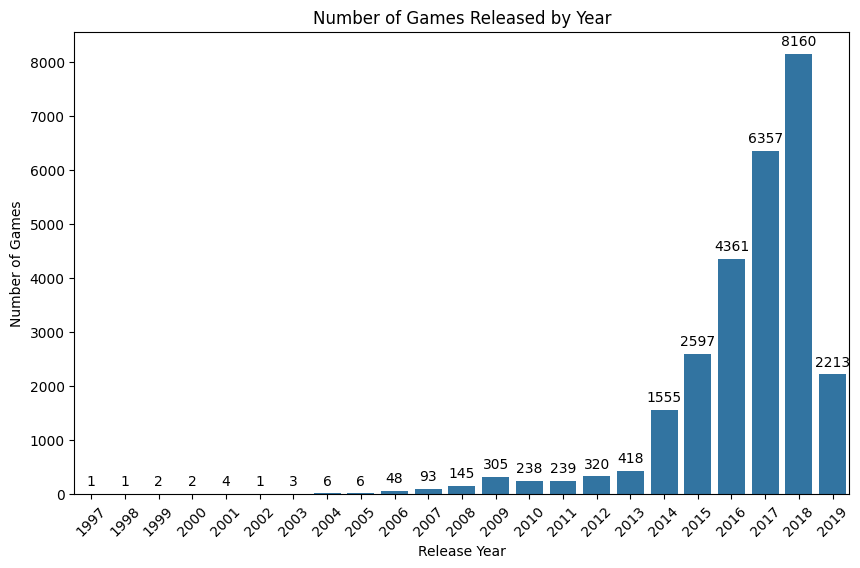

In [21]:
# 게임 출시 연도 분석
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='release_year', data=df)
plt.title('Number of Games Released by Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
# 각 막대에 값 표시
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.show()

- 2008년 이전에 출시된 게임의 수는 너무 작으므로, 대상 데이터는 2008년 ~ 2019년에 출시된 게임으로 한정한다.

## < 2-2 > 카테고리/장르/태그 데이터 구분

In [22]:
def flat_list_to_dict(col):
    col_list=col.values.tolist()
    new_list=[item.split(";") for item in col_list]
    new_col_list=[item for list_in_new_list in new_list for item in list_in_new_list]
    col_dict={i:new_col_list.count(i) for i in set(new_col_list)}
    return {i[0]:i[1] for i in sorted(col_dict.items(), key=lambda item: item[1], reverse=True)}

29


<ipython-input-23-b7df03c4259d>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bp_cat = sns.barplot(x='Count', y=most_frequent_cat_over_300.index, data=most_frequent_cat_over_300, palette="ch:s=.25,rot=-.25")


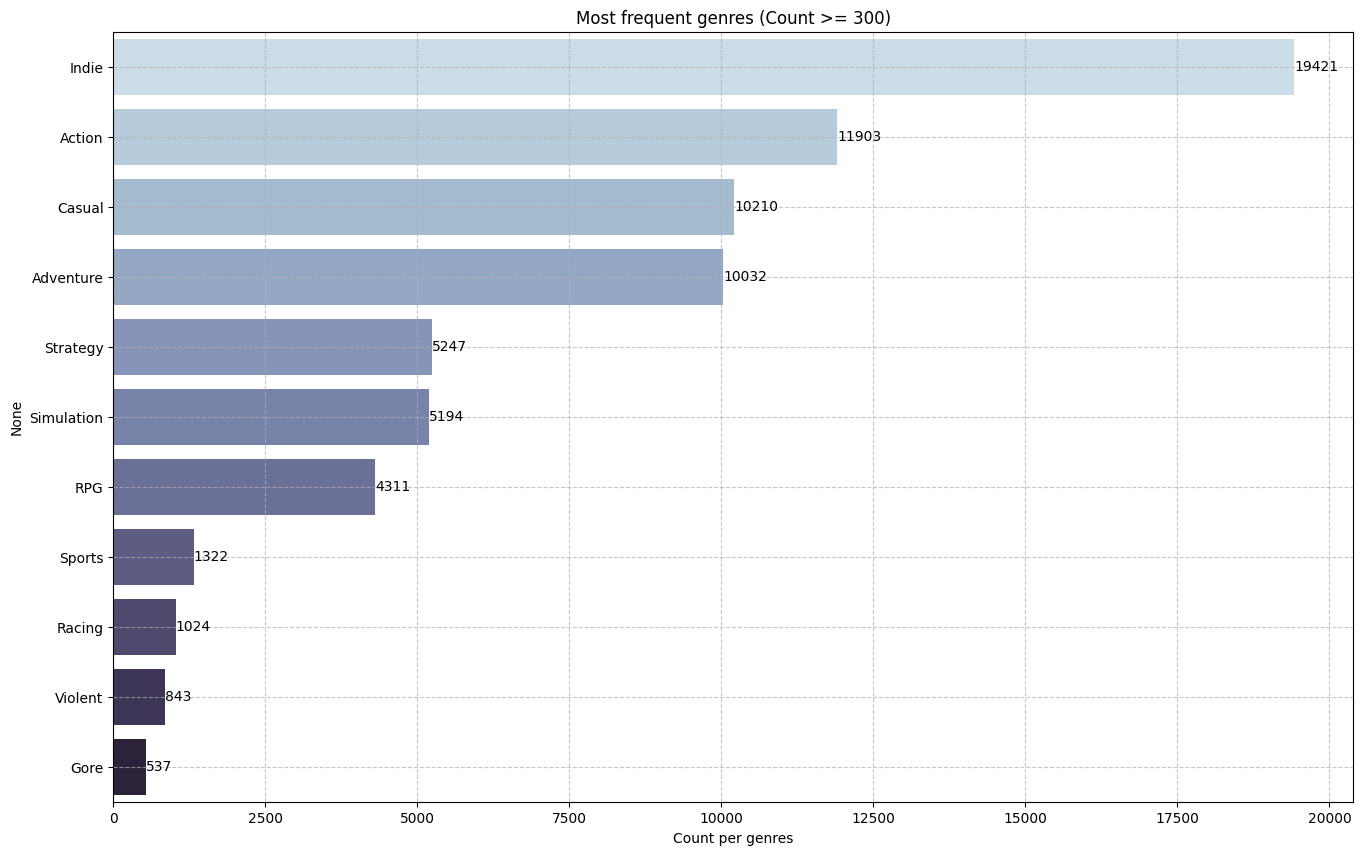

In [23]:
# 장르
cat_dict = flat_list_to_dict(df.genres)
print(len(cat_dict))

# 삭제할 장르 리스트
excluded_genres = ['Free to Play', 'Massively Multiplayer', 'Web Publishing', 'Early Access']

# 장르 딕셔너리에서 삭제할 장르 제거
for genre in excluded_genres:
    cat_dict.pop(genre, None)

plt.figure(figsize=(16, 10))
most_frequent_cat = pd.DataFrame.from_dict(cat_dict, orient='index', columns=['Count'])
most_frequent_cat_over_300 = most_frequent_cat[most_frequent_cat['Count'] >= 300]
bp_cat = sns.barplot(x='Count', y=most_frequent_cat_over_300.index, data=most_frequent_cat_over_300, palette="ch:s=.25,rot=-.25")
bp_cat.set_xlabel('Count per genres')
plt.title("Most frequent genres (Count >= 300)")
plt.grid(True, linestyle='--', alpha=0.7)  # 그리드 추가
# 막대에 값 라벨 붙이기
for p in bp_cat.patches:
    width = p.get_width()
    plt.text(width, p.get_y() + p.get_height() / 2., f'{int(width)}', ha='left', va='center', fontsize=10)
plt.show()

- 장르(genre) 컬럼에서 각각의 장르명이 몇 번 거론되었는지 수를 세었을 때, 다른 장르들에 비해 “Indie” 태그가 압도적으로 많은 수를 차지한다.
- 장르별 게임에 대하여 EDA 및 가설 검정을 진행할 때에 “Indie” 태그를 기준으로 두 그룹(인디 게임, 인디 게임이 아닌 게임(=메이저 게임))으로 나누어서 진행한다.
- 장르별 게임 수 및 출시 비율을 확인할 때, “Indie” 태그는 제외하고 진행한다.


## < 2-3 > 인디 게임과 메이저 게임의 장르별 출시 비율
1. 전체 데이터 : 인디가 포함된 전체
2. 인디 게임 : 인디가 포함된 데이터만
3. 인디가 아닌 게임 : 인디가 제외된 데이터만

** 공통 : 출시 비중 계산할 때 장르에서 'Indie'(+ 장르와 연관 없는 태그)는 제외

In [24]:
# 2008년 이후 데이터 필터링
df_filtered = df[df['release_year'] >= 2008]

In [25]:
# 'genres' 열에서 'indie'를 포함하면 'indie', 포함하지 않으면 'not indie'을 값으로 가지는 열 추가
df_filtered['indie_or_not'] = df_filtered['genres'].apply(lambda x: 'indie' if 'indie' in x.lower() else 'not indie')

### 인기 게임 vs 인디가 아닌 게임

In [26]:
# 'indie'가 있는 행과 없는 행을 분할
df_indie = df_filtered[df_filtered['genres'].str.contains('indie', case=False)]
df_not_indie = df_filtered[~df_filtered['genres'].str.contains('indie', case=False)]

df_filtered.shape, df_indie.shape, df_not_indie.shape

((26908, 24), (19402, 24), (7506, 24))

In [27]:
# release_year 및 indie_or_not에 따른 게임 출시 수 계산
grouped_data = df_filtered.groupby(['release_year', 'indie_or_not']).size().reset_index(name='counts')

# 연도별 전체 게임 출시 수 계산
total_counts_by_year = grouped_data.groupby('release_year')['counts'].sum()

# 연도별 인디 게임의 비율(%) 계산하여 추가
grouped_data['ratio_percent'] = (grouped_data['counts'] / total_counts_by_year[grouped_data['release_year']].values) * 100
grouped_data

,release_year,indie_or_not,counts,ratio_percent
0,2008,indie,23,15.862069
1,2008,not indie,122,84.137931
2,2009,indie,59,19.344262
3,2009,not indie,246,80.655738
4,2010,indie,64,26.890756
5,2010,not indie,174,73.109244
6,2011,indie,97,40.585774
7,2011,not indie,142,59.414226
8,2012,indie,167,52.187500
9,2012,not indie,153,47.812500


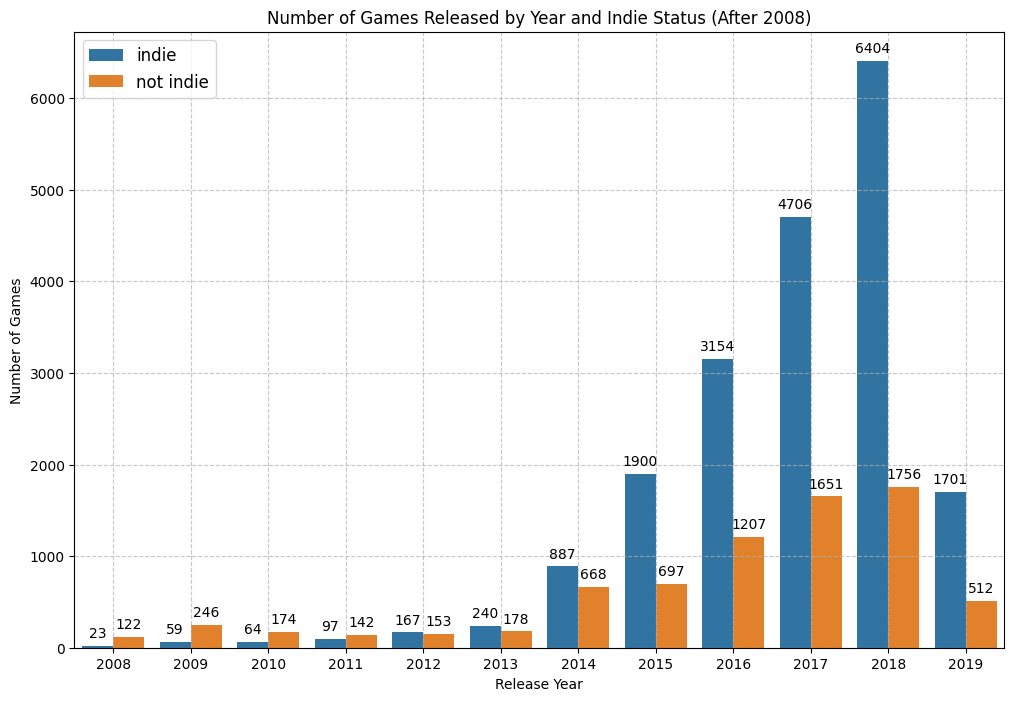

In [28]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='release_year', y='counts', hue='indie_or_not', data=grouped_data)
plt.title('Number of Games Released by Year and Indie Status (After 2008)')
plt.xlabel('Release Year')
plt.ylabel('Number of Games')
plt.legend(loc='upper left', fontsize='large')
plt.xticks()
plt.grid(True, linestyle='--', alpha=0.7)  # 그리드 추가
# 막대에 값 라벨 붙이기
for p in ax.patches:
    height = p.get_height()
    if height != 0:
        ax.annotate(format(height, '.0f'),
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points')
plt.show()

- 인디 게임과 메이저 게임 모두 2008년부터 2019년까지 연도별로 증가하는 추세를 보인다.
- 인디 게임은 2013년부터 급격하게 증가하는 경향을 보이며, 2015년 이후에는 그 증가폭이 매우 크며 인디 게임의 출시 수가 메이저 게임의 출시 수보다 상당히 많다.
- 메이저 게임은 인디 게임에 비해서는 출시된 게임 수의 증가폭이 완만한 편이다.


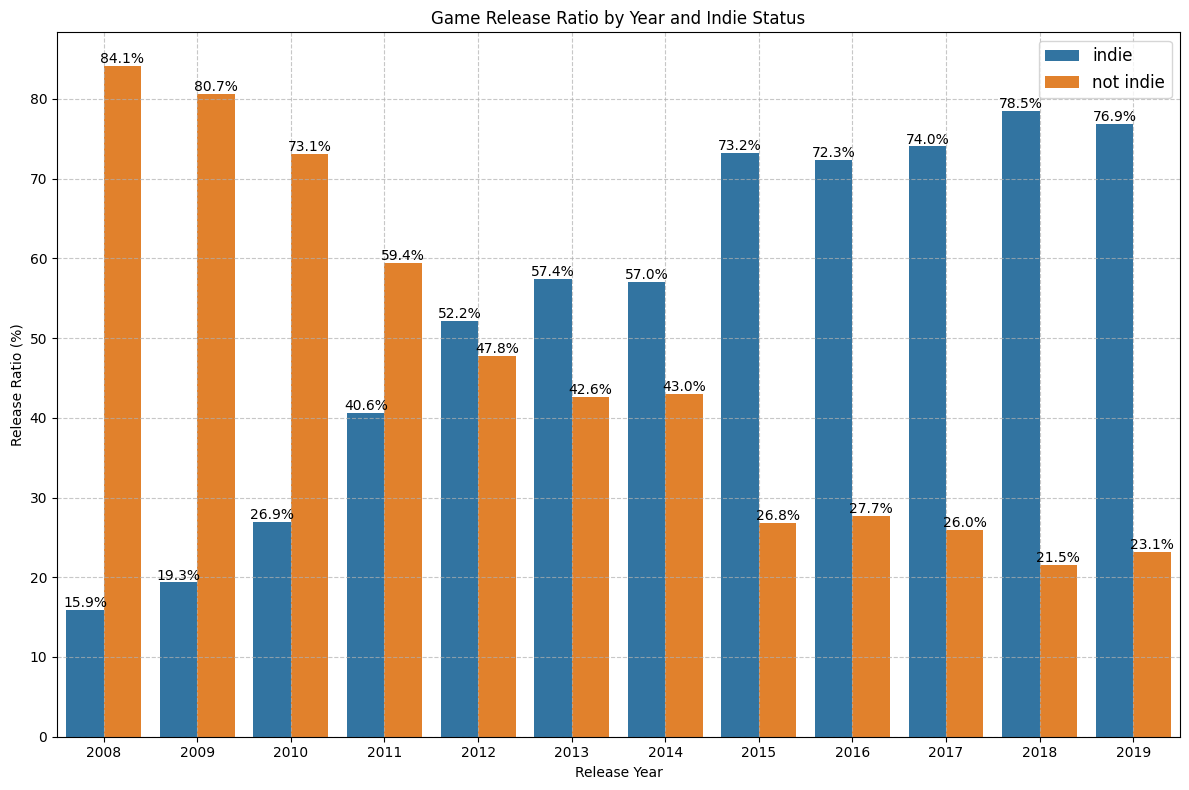

In [29]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=grouped_data, x='release_year', y='ratio_percent', hue='indie_or_not')
plt.title('Game Release Ratio by Year and Indie Status')
plt.xlabel('Release Year')
plt.ylabel('Release Ratio (%)')
plt.xticks()
plt.legend(loc='upper right', fontsize='large')
plt.grid(True, linestyle='--', alpha=0.7)

# 막대에 값 라벨 붙이기
for p in ax.patches:
    height = p.get_height()
    if height != 0:
        ax.annotate('{:.1f}%'.format(height),
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.show()


- 하지만 연도별 인디 게임과 메이저 게임의 출시 비중은 음의 상관관계를 보인다.
  - 인디 게임은 시간이 지날수록 출시 비중이 증가하는 추세를 보인다.
  - 반대로 메이저 게임의 출시 비중은 시간이 지날수록 감소하는 추세를 보인다.
- 2008년부터 2011년까지는 메이저 게임의 출시 비중이 압도적으로 컸으나, 2012년부터는 인디 게임의 출시 비중이 메이저 게임의 것보다 크며, 2015년부터는 그 차이가 더 커지고 있음을 확인할 수 있다.

### # 그래프

In [30]:
def preprocess_data(df):
    # 장르를 여러 개의 열로 분할하고 각 열에 대해 행을 분리
    df_split_genres = df.assign(genres=df['genres'].str.split(';')).explode('genres')

    # 불필요한 장르 값을 제외한 데이터프레임 생성
    excluded_genres = ['indie', 'free to play', 'massively multiplayer', 'web publishing', 'early access']
    excluded_genres_pattern = '|'.join(excluded_genres)
    df_split_genres = df_split_genres[~df_split_genres['genres'].str.contains(excluded_genres_pattern, case=False)]

    return df_split_genres

- 'Indie' 장르는 분석 대상 데이터에서 제외한다.
- 게임 장르 구분과 연관이 없는 태그는 삭제한다.

In [31]:
def calculate_genre_release_counts(df):
    # 각 연도별로 장르별 출시 횟수 계산
    genre_counts_by_year = df.groupby(['release_year', 'genres']).size().reset_index(name='counts')

    # 각 연도별 전체 출시 게임 수 계산
    total_counts_by_year = genre_counts_by_year.groupby('release_year')['counts'].sum()

    # 각 연도별로 장르별 출시 비율 계산
    genre_counts_by_year['ratio'] = genre_counts_by_year.apply(lambda x: x['counts'] / total_counts_by_year[x['release_year']], axis=1)

    return genre_counts_by_year, total_counts_by_year

In [32]:
def plot_genre_release_ratio(genre_counts_by_year, total_counts_by_year, title):
    plt.figure(figsize=(15, 10))
    # 그래프가 그려진 장르만 필터링
    genres_to_plot = genre_counts_by_year['genres'].unique()
    data_to_plot = genre_counts_by_year[genre_counts_by_year['genres'].isin(genres_to_plot)]
    for genre in genres_to_plot:
        genre_data = data_to_plot[data_to_plot['genres'] == genre]
        plt.plot(genre_data['release_year'], genre_data['ratio'], label=genre)
    plt.title(title)
    plt.xlabel('Release Year')
    plt.ylabel('Release Ratio')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.xticks(range(min(genre_counts_by_year['release_year']), max(genre_counts_by_year['release_year'])+1))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

### # 그래프 기울기

In [33]:
def calculate_slope_by_genre(df, start_year, end_year):
    # 시작 연도와 종료 연도 사이의 데이터만 필터링
    df_subset = df[(df['release_year'] >= start_year) & (df['release_year'] <= end_year)]

    # 해당 연도 구간의 출시 비율 데이터 가져오기
    genre_counts_by_year_subset = df_subset.groupby(['release_year', 'genres']).size().reset_index(name='counts')
    total_counts_by_year_subset = genre_counts_by_year_subset.groupby('release_year')['counts'].sum()
    genre_counts_by_year_subset['ratio'] = genre_counts_by_year_subset.apply(lambda x: x['counts'] / total_counts_by_year_subset[x['release_year']], axis=1)

    # 장르별 기울기 계산
    genre_slopes = {}
    for genre in genre_counts_by_year_subset['genres'].unique():
        genre_data = genre_counts_by_year_subset[genre_counts_by_year_subset['genres'] == genre]
        start_ratio = genre_data.loc[genre_data['release_year'] == start_year, 'ratio'].values
        end_ratio = genre_data.loc[genre_data['release_year'] == end_year, 'ratio'].values
        if len(start_ratio) == 0 or len(end_ratio) == 0:
            # 해당 장르가 해당 연도에 출시되지 않은 경우 기울기를 0으로 처리
            slope = 0
        else:
            slope = (end_ratio[0] - start_ratio[0]) / (end_year - start_year)
        genre_slopes[genre] = slope

    return genre_slopes

In [34]:
# 각 연도 구간별 장르별 기울기 계산 및 데이터프레임 생성
start_years = [year for year in range(2008, 2019)]  # 구간의 시작 연도
end_years = [year + 1 for year in start_years]      # 구간의 종료 연도
slope_data_indie = {'genre': list(preprocess_data(df_indie)['genres'].unique())}
slope_data_not_indie = {'genre': list(preprocess_data(df_not_indie)['genres'].unique())}
slpoe_data_all = {'genre': list(preprocess_data(df_filtered)['genres'].unique())}
for i in range(len(start_years)):
    start_year = start_years[i]
    end_year = end_years[i]
    slopes_indie = calculate_slope_by_genre(preprocess_data(df_indie), start_year, end_year)
    slopes_not_indie = calculate_slope_by_genre(preprocess_data(df_not_indie), start_year, end_year)
    slpoe_all = calculate_slope_by_genre(preprocess_data(df_filtered), start_year, end_year)
    slope_col_name = f"{start_year}-{end_year}"
    slope_data_indie[slope_col_name] = [slopes_indie.get(genre, 0) for genre in slope_data_indie['genre']]
    slope_data_not_indie[slope_col_name] = [slopes_not_indie.get(genre, 0) for genre in slope_data_not_indie['genre']]
    slpoe_data_all[slope_col_name] = [slpoe_all.get(genre, 0) for genre in slpoe_data_all['genre']]

# 데이터프레임 생성
slope_df_indie = pd.DataFrame(slope_data_indie)
slope_df_not_indie = pd.DataFrame(slope_data_not_indie)
slpoe_df_all = pd.DataFrame(slpoe_data_all)

# 연도별 기울기 값이 모두 0인 행 삭제
slope_df_indie = slope_df_indie[(slope_df_indie.iloc[:, 1:] != 0).any(axis=1)]
slope_df_not_indie = slope_df_not_indie[(slope_df_not_indie.iloc[:, 1:] != 0).any(axis=1)]
slpoe_df_all = slpoe_df_all[(slpoe_df_all.iloc[:, 1:] != 0).any(axis=1)]

### 1. 인디 게임 데이터

In [35]:
genre_counts_by_year_indie, total_counts_by_year_indie = calculate_genre_release_counts(preprocess_data(df_indie))
# for year in range(2008,2019):
#     print(genre_counts_by_year_indie[genre_counts_by_year_indie['release_year']==year])
#     print()
genre_counts_by_year_indie

,release_year,genres,counts,ratio
0,2008,Action,7,0.241379
1,2008,Adventure,1,0.034483
2,2008,Casual,9,0.310345
3,2008,RPG,2,0.068966
4,2008,Racing,2,0.068966
...,...,...,...,...
134,2019,Racing,60,0.017757
135,2019,Simulation,370,0.109500
136,2019,Sports,85,0.025155
137,2019,Strategy,340,0.100621


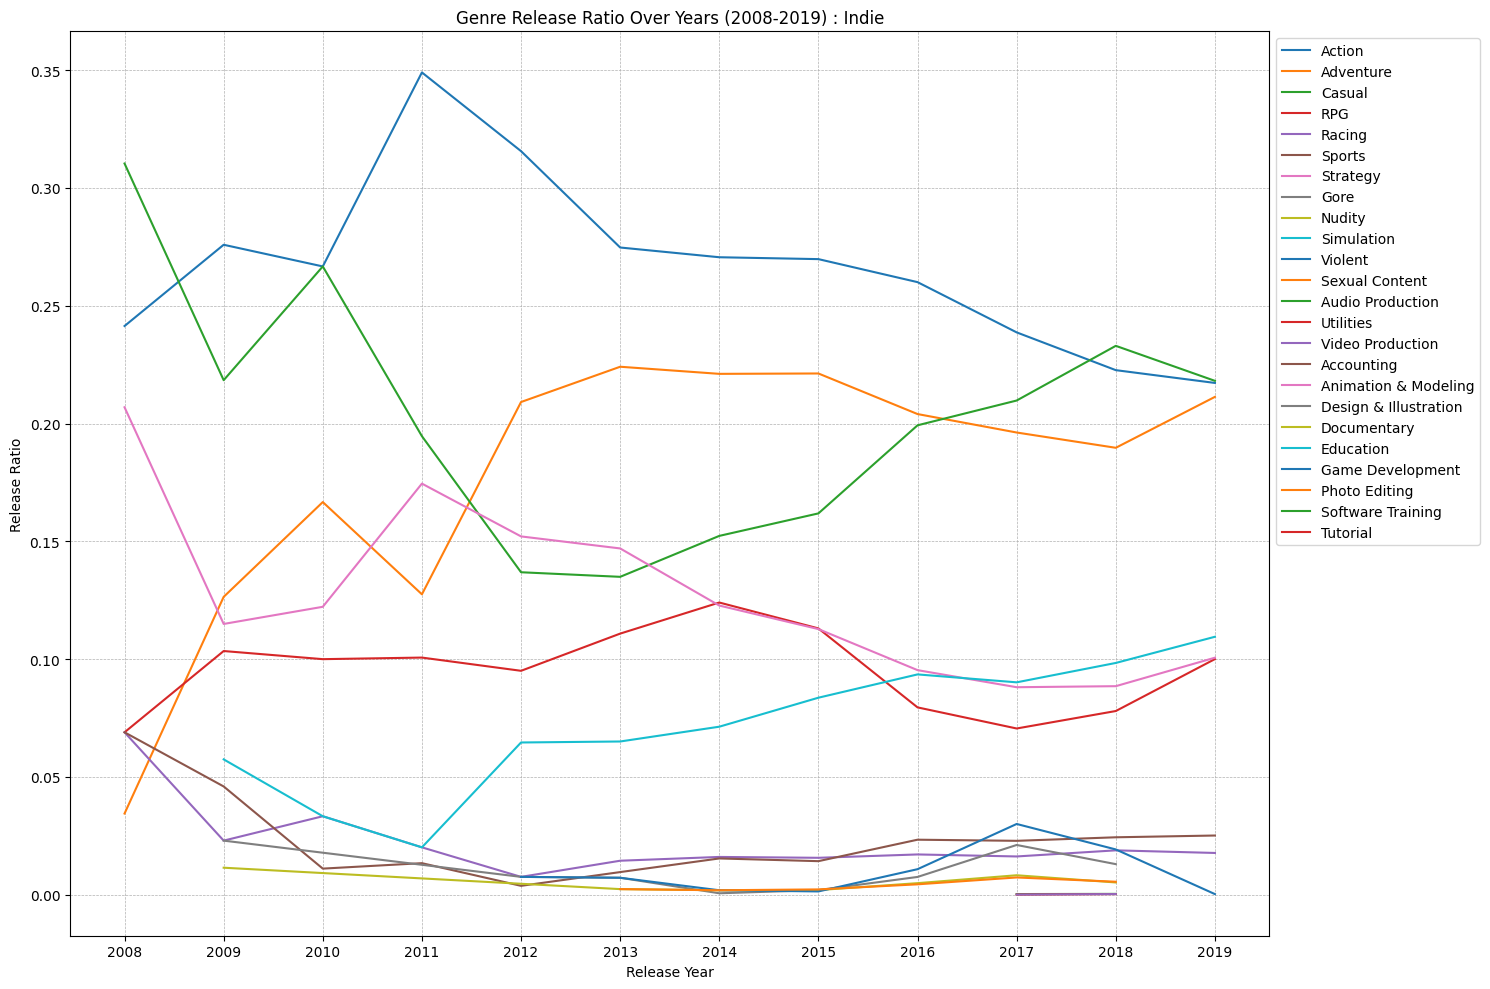

In [36]:
plot_genre_release_ratio(genre_counts_by_year_indie, total_counts_by_year_indie, 'Genre Release Ratio Over Years (2008-2019) : Indie')

In [37]:
slope_df_indie

,genre,2008-2009,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019
0,Action,0.034483,-0.009195,0.082327,-0.033404,-0.040891,-0.004133,-0.000797,-0.009765,-0.021326,-0.016028,-0.005426
1,Strategy,-0.091954,0.007280,0.052274,-0.022405,-0.005103,-0.024237,-0.009990,-0.017420,-0.007248,0.000444,0.012085
2,Casual,-0.091954,0.048276,-0.072036,-0.057749,-0.001942,0.017374,0.009548,0.037381,0.010520,0.023204,-0.014854
3,Racing,-0.045977,0.010345,-0.013199,-0.012530,0.006853,0.001609,-0.000366,0.001424,-0.000854,0.002591,-0.001105
4,Sports,-0.022989,-0.034866,0.002312,-0.009621,0.005836,0.005786,-0.001151,0.009109,-0.000478,0.001501,0.000750
5,RPG,0.034483,-0.003448,0.000671,-0.005614,0.015786,0.013193,-0.010990,-0.033514,-0.008955,0.007412,0.022041
6,Adventure,0.091954,0.040230,-0.039150,0.081609,0.014971,-0.003017,0.000159,-0.017221,-0.007832,-0.006487,0.021606
7,Nudity,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000482,0.000070,0.002942,0.003351,-0.003056,0.000000
8,Gore,0.000000,0.000000,0.000000,0.000000,-0.000376,-0.006586,0.001356,0.005576,0.013568,-0.008131,0.000000
9,Simulation,0.000000,-0.024138,-0.013199,0.044505,0.000421,0.006277,0.012306,0.009886,-0.003364,0.008226,0.011109


1. Action
  - 2008~2009년과 2010~2011년에는 출시 비율이 증가했다.
  - 2011년 이후부터는 감소하는 경향을 보인다.
2. Adventure
  - 2011~2012년에는 출시 비율이 감소했지만, 전반적으로 증가하는 추세를 보인다.
3. Casual
  - 2012년 이전까지는 출시 비율이 감소하는 경향을 보이며, 2009~2010년에는 잠시 출시 비율이 증가했다.
  - 2012년부터는 전반적으로 출시 비율이 증가하는 경향을 보인다.
4. Strategy
  - 2009~2011년에는 잠시 출시 비율이 증가했지만, 전반적으로 출시 비율이 감소하는 경향을 보인다.
  - 특히 2011년부터는 꾸준하게 출시 비율이 감소했다.
5. Simulation
  - 2009~2011년에는 출시 비율이 감소하는 경향을 보인다.
  - 2011년부터는 출시 비율이 증가했다.
6. RPG
  - 2008~2014년에는 출시 비율이 증가는 경향을 보인다.
  - 2014~2017년까지 출시 비율이 감소하다가 2017년부터는 다시 증가하는 추세를 보인다.
7. Racing
  - 출시 비율에 큰 변화는 없지만 출시 비율이 약간 감소하는 경향을 보인다.
8. Sports
  - 2008~2010년에는 출시 비율이 감소했다.
  - 2010년부터는 대체로 비슷한 출시 비율을 유지하며 약간의 증가 추세를 보인다.
- 나머지 장르들은 출시 비율이 크게 변화하지 않거나 변화가 없다.


### 2. 인데 게임 제외한 데이터

In [38]:
genre_counts_by_year_not_indie, total_counts_by_year_not_indie = calculate_genre_release_counts(preprocess_data(df_not_indie))
# for year in range(2008,2019):
#     print(genre_counts_by_year_not_indie[genre_counts_by_year_not_indie['release_year']==year])
#     print()
genre_counts_by_year_not_indie

,release_year,genres,counts,ratio
0,2008,Action,54,0.333333
1,2008,Adventure,22,0.135802
2,2008,Casual,24,0.148148
3,2008,RPG,11,0.067901
4,2008,Racing,9,0.055556
...,...,...,...,...
171,2019,Simulation,105,0.122664
172,2019,Sports,20,0.023364
173,2019,Strategy,96,0.112150
174,2019,Utilities,12,0.014019


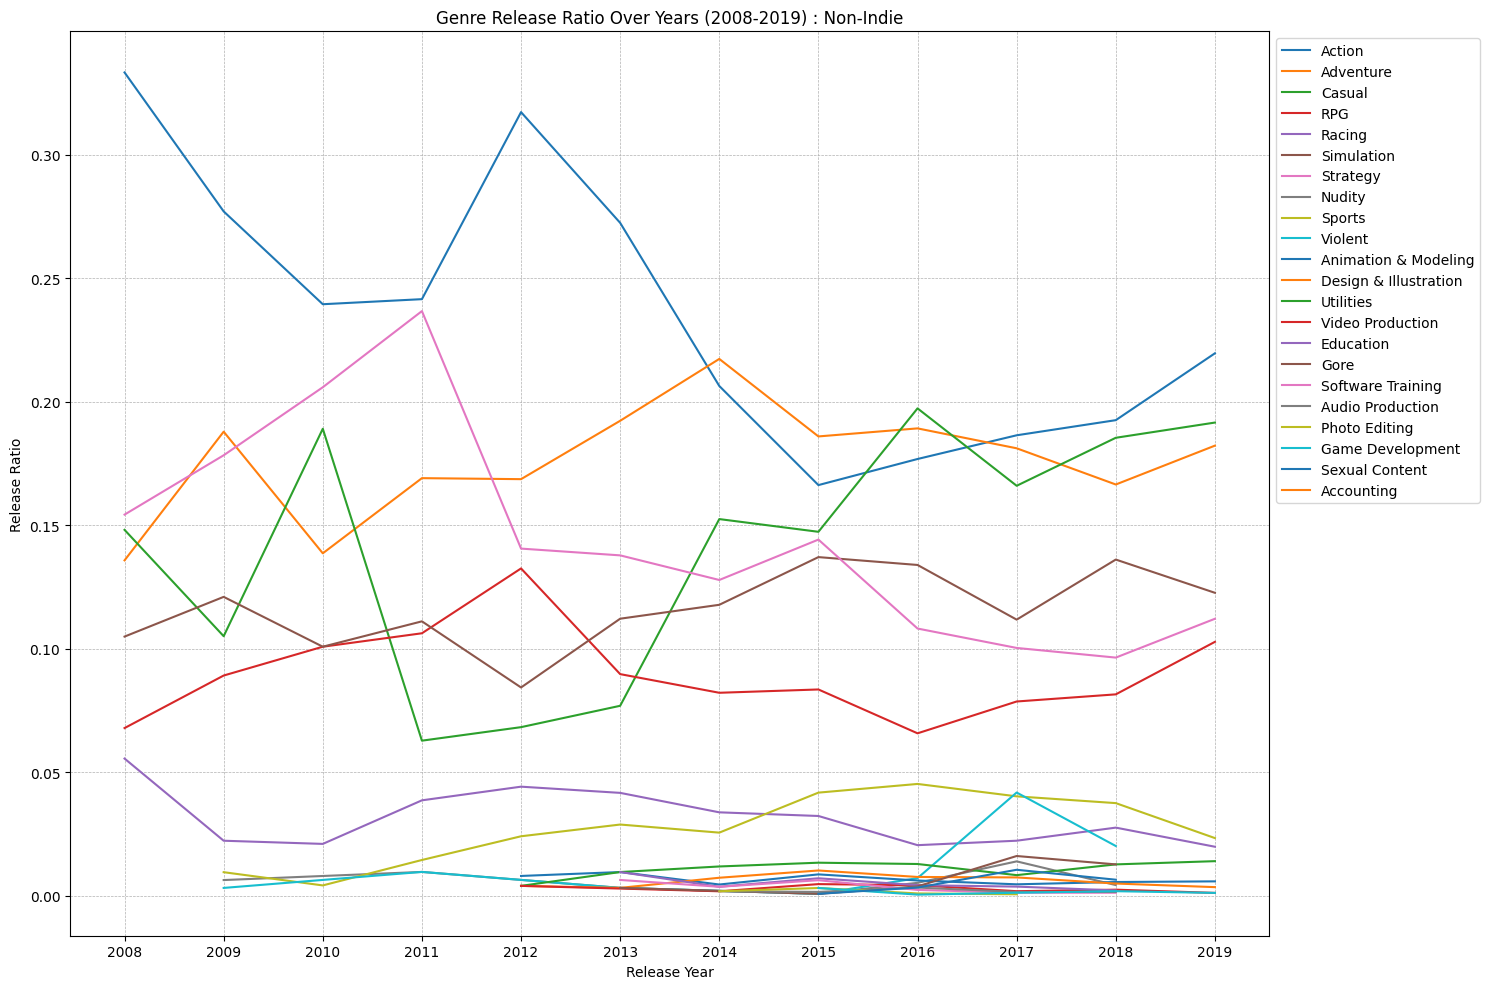

In [39]:
# 'indie' 미포함된 데이터프레임에 대한 시각화
plot_genre_release_ratio(genre_counts_by_year_not_indie, total_counts_by_year_not_indie, 'Genre Release Ratio Over Years (2008-2019) : Non-Indie')

In [40]:
slope_df_not_indie

,genre,2008-2009,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019
0,Action,-0.056263,-0.037574,0.002050,0.075723,-0.044833,-0.066043,-0.040120,0.010562,0.009600,0.006123,0.027068
1,Strategy,0.024023,0.027538,0.030833,-0.096153,-0.002742,-0.009967,0.016354,-0.036010,-0.007858,-0.003907,0.015715
2,Adventure,0.052096,-0.049243,0.030427,-0.000407,0.023633,0.025044,-0.031378,0.003255,-0.008057,-0.014659,0.015731
3,Animation & Modeling,0.000000,0.000000,0.000000,0.000000,0.001583,-0.005049,0.004102,-0.002472,-0.001551,0.000936,0.000260
4,Video Production,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002902,-0.000438,-0.002432,0.000622,-0.001312
5,RPG,0.021271,0.011668,0.005440,0.026250,-0.042787,-0.007552,0.001339,-0.017753,0.012885,0.002888,0.021253
6,Simulation,0.016081,-0.020179,0.010271,-0.026774,0.027842,0.005629,0.019308,-0.003179,-0.022138,0.024325,-0.013460
7,Racing,-0.033263,-0.001285,0.017639,0.005529,-0.002510,-0.007877,-0.001481,-0.011813,0.001802,0.005299,-0.007737
8,Casual,-0.043053,0.083980,-0.126274,0.005471,0.008650,0.075588,-0.005151,0.049971,-0.031335,0.019431,0.006162
9,Nudity,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004455,0.008693,-0.009595,0.000000


1. Action
  - 2011~2012년에 출시 비율이 급격한 증가했으며, 이후 2015년까지는 출시 비율이 감소하는 경향을 보인다.
  - 2015년부터는 출시 비율이 증가하는 추세를 보인다.
2. Adventure
  - 2010~2014년에는 출시 비율이 증가했다.
  - 2014~2018년에는 출시 비율이 감소하는 경향을 보인다.
3. Casual
  - 2008~2009년, 2010~2011년, 2016~2017년을 제외하고는 대체로 출시 비율이 증가하는 추세를 보인다.
4. Strategy
  - 2011년까지 출시 비율이 꾸준하게 증가했지만, 이후부터는 출시 비율이 감소하는 경향을 보인다.
5. Simulation
  - 2011~2012년, 2016~2017년, 2018~2019년을 제외하고는 대체로 출시 비율이 완만하게 증가하는 추세를 보인다.
6. RPG
  - 2008~2012년에는 출시 비율이 증가하다가, 2012~2018년에는 출시 비율이 감소하는 추세를 보인다.
  - 2016년부터는 출시 비율이 증가하는 추세를 보인다.
7. Racing
  - 2008~2009년에는 출시 비율이 감소했다.
  - 이후부터는 일정 비율을 유지하며 완만하게 증가와 감소를 반복하는 경향을 보인다.
8. Sports
  - 2016년까지 출시 비율이 완만하게 증가했지만, 이후부터는 완만하게 감소하는 경향을 보인다.
- 나머지 장르들은 출시 비율이 크게 변화하지 않거나 변화가 없다.


### 3. 전체 데이터

In [41]:
genre_counts_by_year_indie, total_counts_by_year_indie = calculate_genre_release_counts(preprocess_data(df_filtered))
# for year in range(2008,2019):
#     print(genre_counts_by_year_indie[genre_counts_by_year_indie['release_year']==year])
#     print()

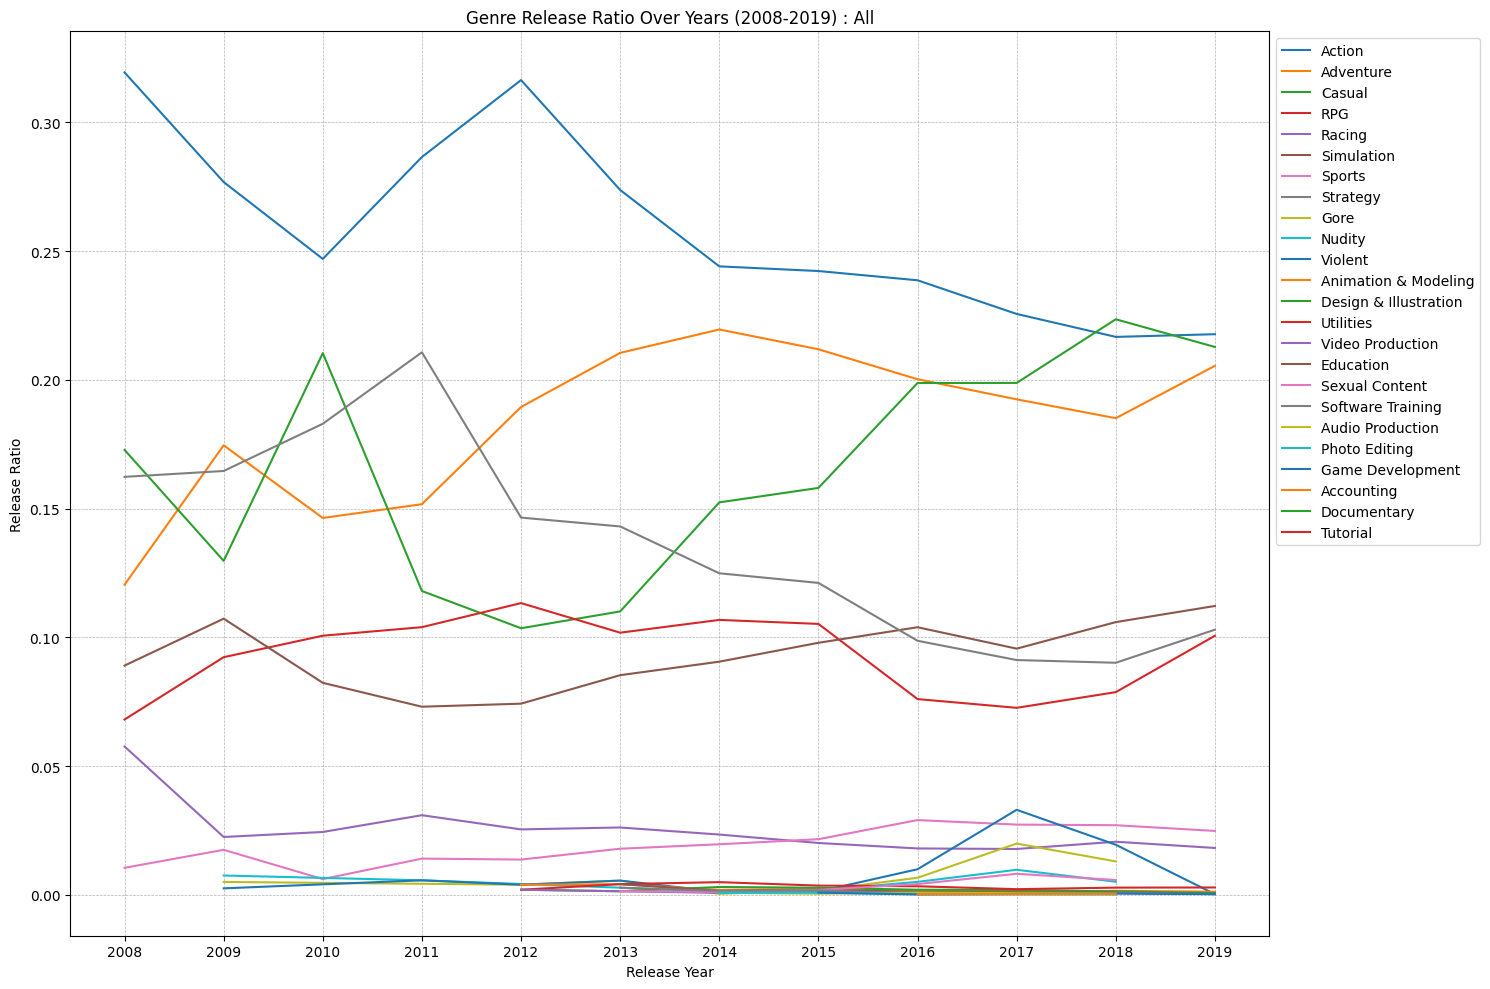

In [42]:
plot_genre_release_ratio(genre_counts_by_year_indie, total_counts_by_year_indie, 'Genre Release Ratio Over Years (2008-2019) : All')

In [43]:
slpoe_df_all

,genre,2008-2009,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018,2018-2019
0,Action,-0.042564,-0.029857,0.039566,0.029889,-0.042679,-0.029669,-0.001812,-0.003598,-0.013070,-0.008914,0.001045
1,Strategy,0.002285,0.018338,0.027747,-0.064190,-0.003431,-0.018195,-0.003735,-0.022482,-0.007478,-0.001056,0.012844
2,Adventure,0.054145,-0.028222,0.005344,0.037768,0.021001,0.009086,-0.007679,-0.011641,-0.007799,-0.007334,0.020344
3,Animation & Modeling,0.000000,0.000000,0.000000,0.000000,0.000220,-0.002240,0.000419,-0.000714,-0.000426,0.000377,-0.000361
4,Video Production,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000503,-0.000156,-0.000558,0.000197,-0.000504
5,RPG,0.024206,0.008340,0.003323,0.009349,-0.011493,0.004964,-0.001555,-0.029196,-0.003396,0.006093,0.021893
6,Simulation,0.018227,-0.024915,-0.009283,0.001185,0.011063,0.005250,0.007331,0.006042,-0.008315,0.010307,0.006264
7,Racing,-0.035148,0.001946,0.006509,-0.005508,0.000744,-0.002747,-0.003270,-0.002127,-0.000208,0.002817,-0.002418
8,Casual,-0.043099,0.080690,-0.092388,-0.014462,0.006526,0.042354,0.005610,0.040747,0.000037,0.024722,-0.010760
9,Nudity,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001619,0.000545,0.003341,0.004689,-0.004649,0.000000


# [ 3 ] 가설 검증

## 가설 : 장르별로 인디 게임과 메이저 게임의 출시되는 게임 비율의 변화는 다를 것이다.

  - 데이터 수가 너무 적은 장르들은 제외
    - 'Action', 'Adventure', 'Casual', 'Strategy', 'Simulation', 'RPG', 'Racing', 'Sports'에 대해서만 확인
  - 각 장르별로 전체 게임의 수가 다르므로 데이터 정규성 확인

In [44]:
# Indie 게임과 Non-Indie 게임 데이터 프레임 생성
indie_df = pd.DataFrame(genre_counts_by_year_indie)
major_df = pd.DataFrame(genre_counts_by_year_not_indie)

# 분석에 사용할 장르 리스트
selected_genres = ['Action', 'Adventure', 'Casual', 'Strategy', 'Simulation', 'RPG', 'Racing', 'Sports']

### 1. 데이터 정규성 확인 (Shapiro-Wilk Test)

In [45]:
indie_df.head()

,release_year,genres,counts,ratio
0,2008,Action,61,0.319372
1,2008,Adventure,23,0.120419
2,2008,Casual,33,0.172775
3,2008,RPG,13,0.068063
4,2008,Racing,11,0.057592


<< Action >>
[Indie] p-value: 0.20352661609649658 - 정규 분포를 따른다.
[Major] p-value: 0.4804408550262451 - 정규 분포를 따른다.



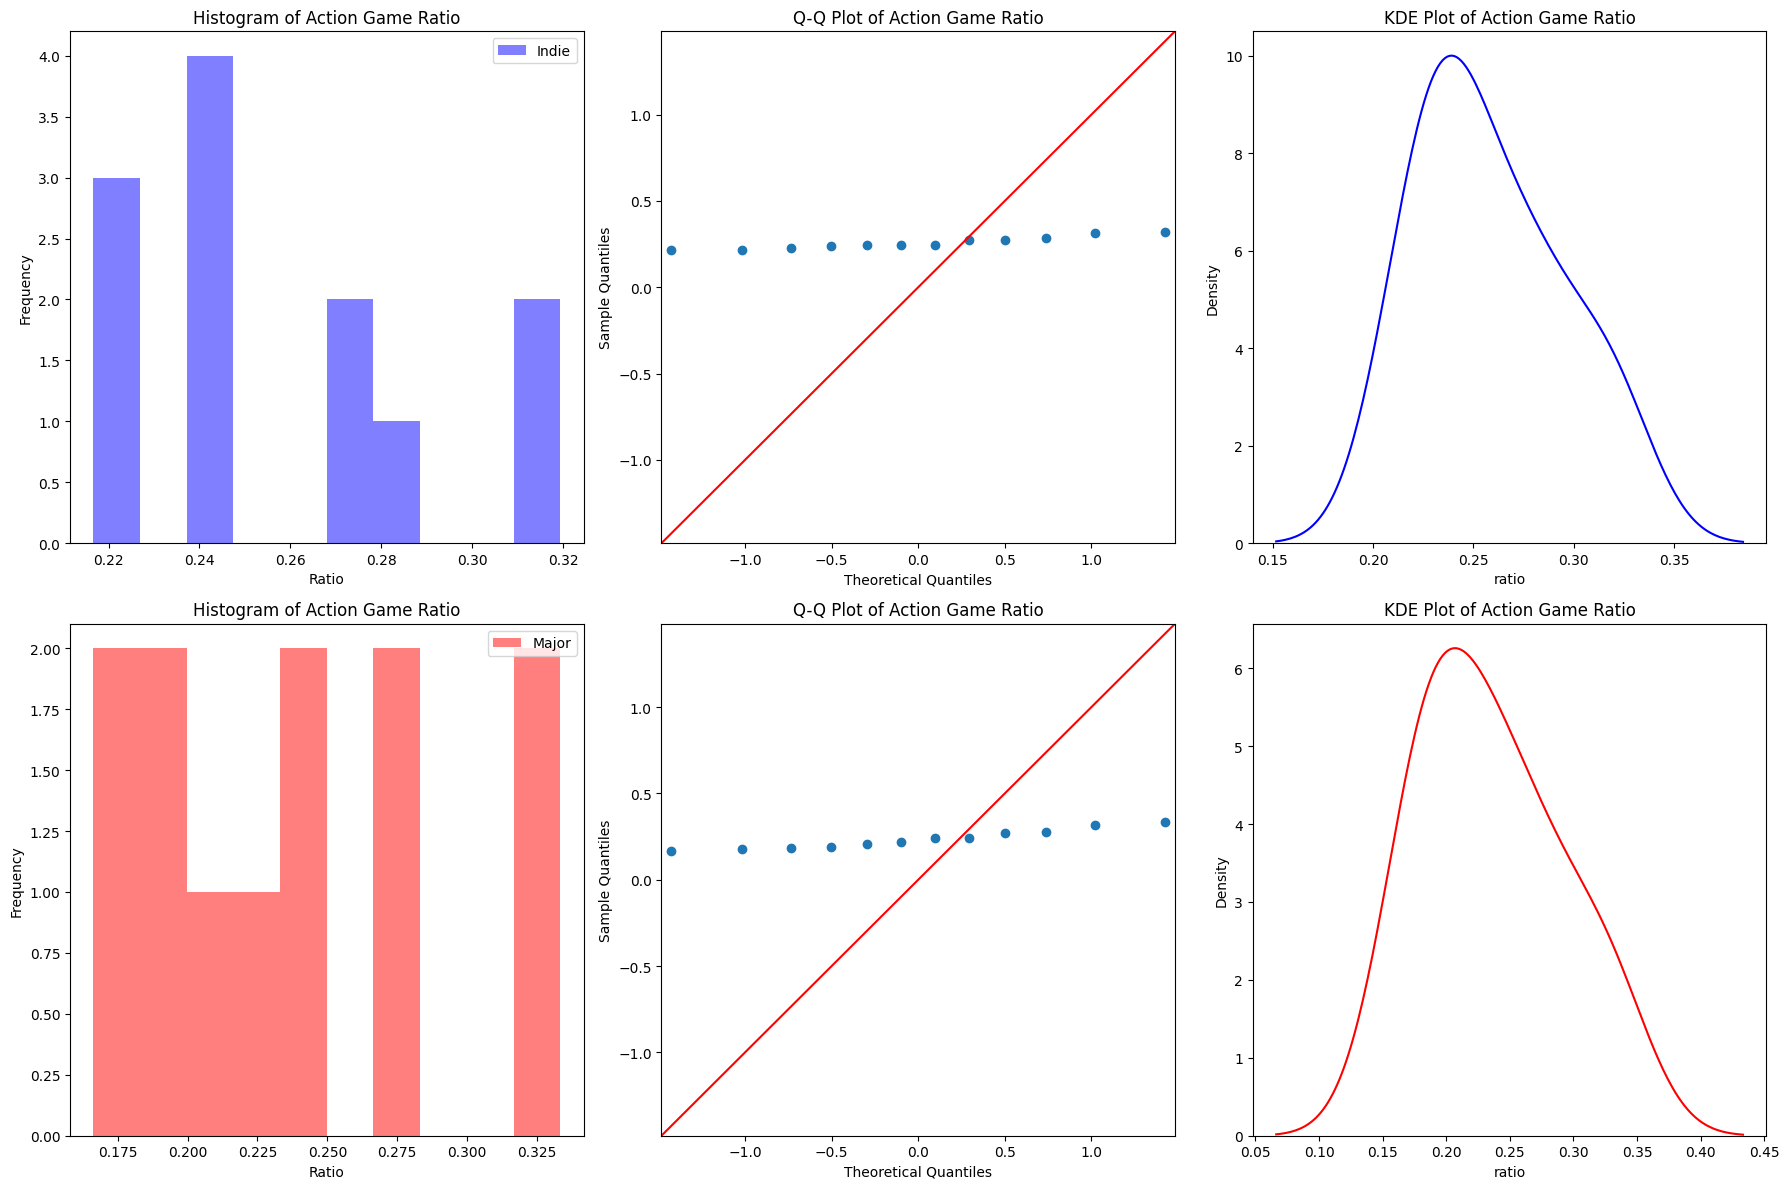

<< Adventure >>
[Indie] p-value: 0.22396913170814514 - 정규 분포를 따른다.
[Major] p-value: 0.3579622805118561 - 정규 분포를 따른다.



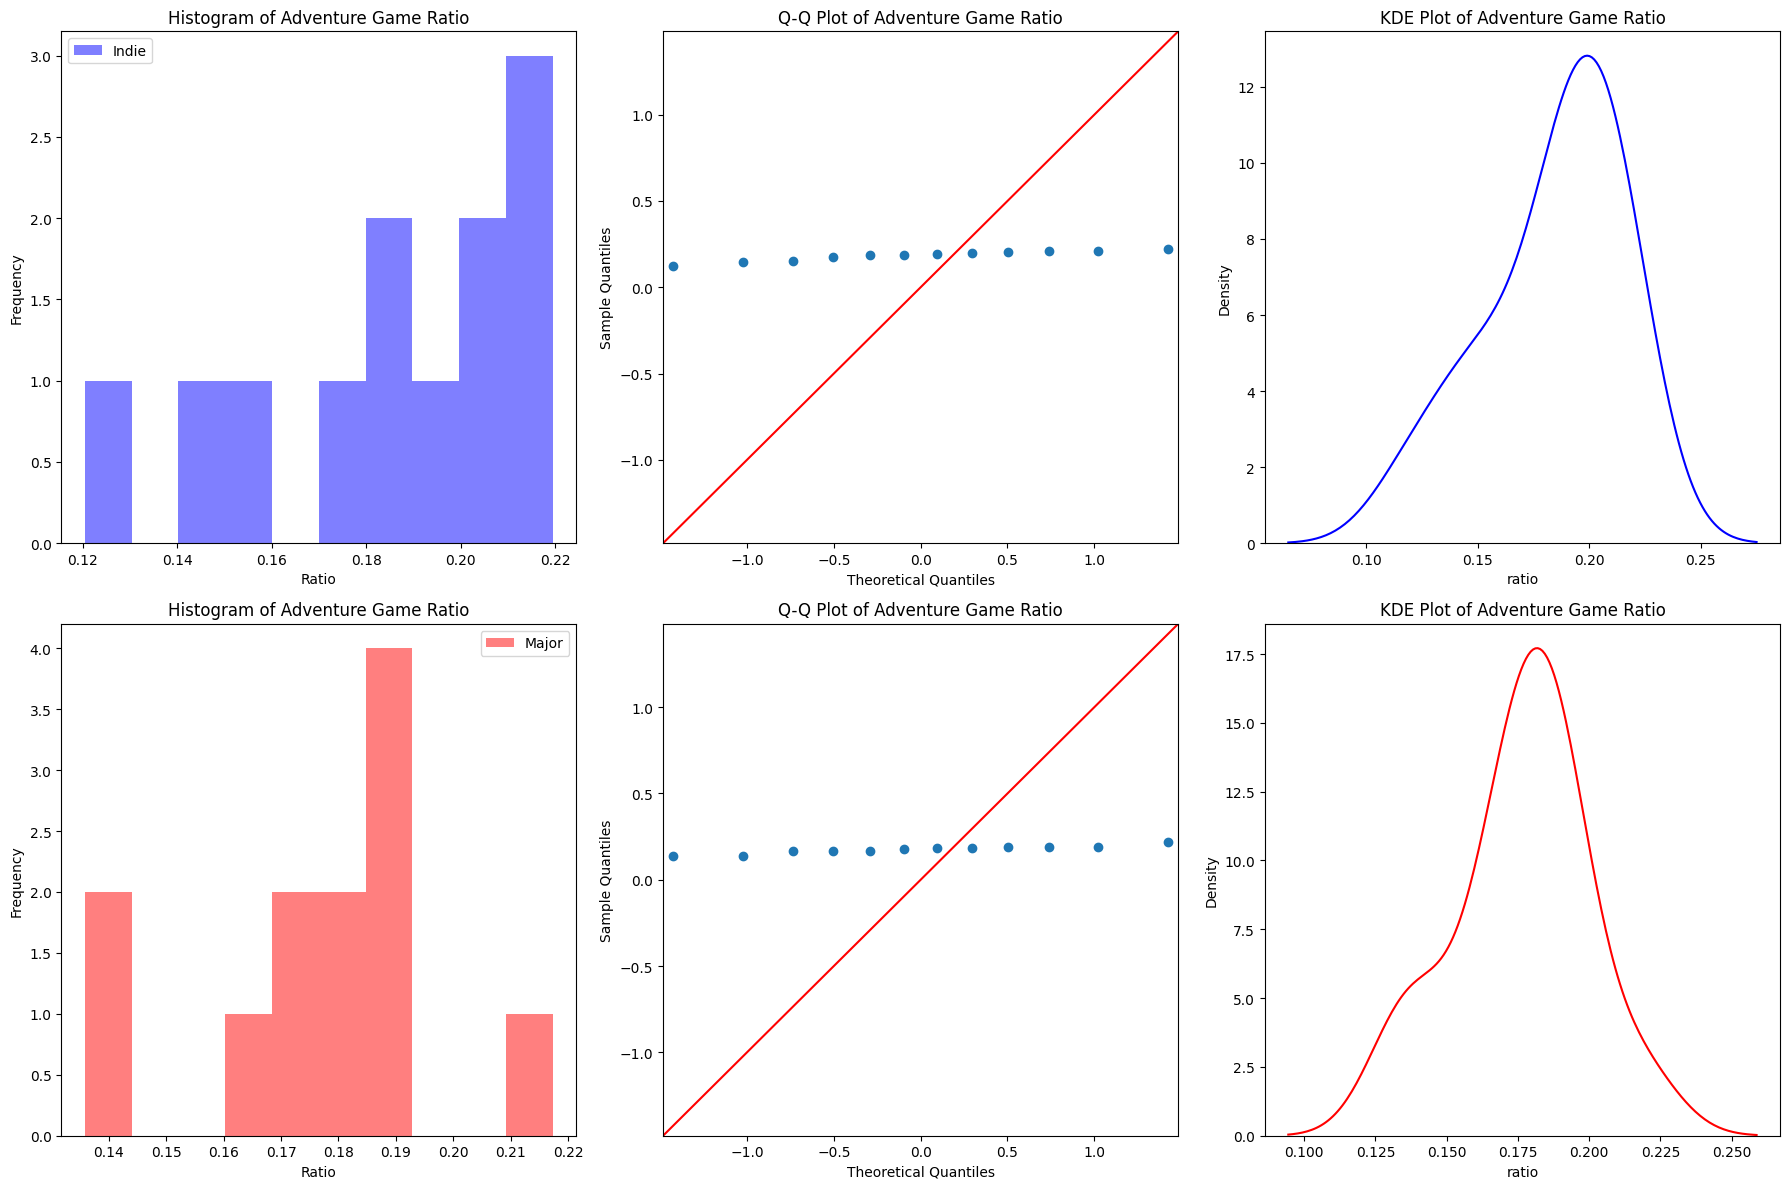

<< Casual >>
[Indie] p-value: 0.25259312987327576 - 정규 분포를 따른다.
[Major] p-value: 0.07545658946037292 - 정규 분포를 따른다.



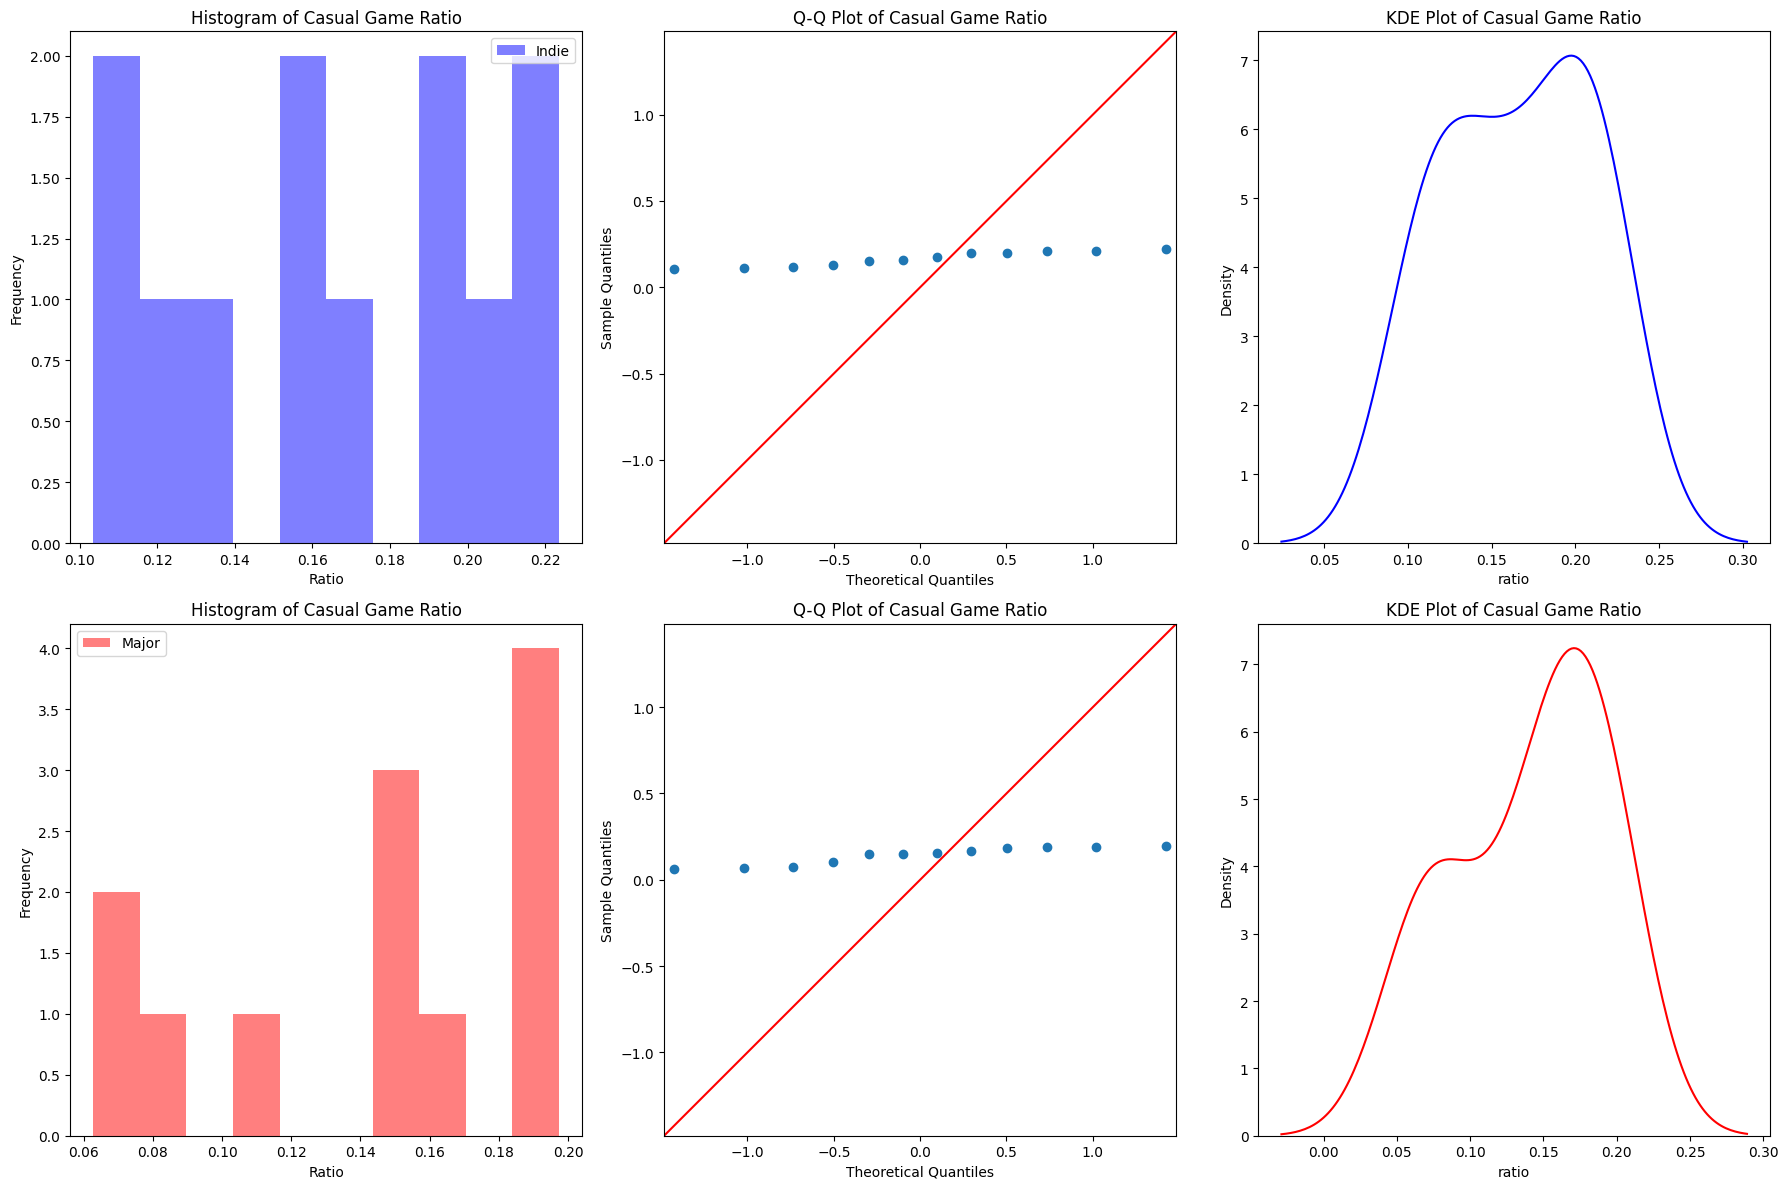

<< Strategy >>
[Indie] p-value: 0.5338099002838135 - 정규 분포를 따른다.
[Major] p-value: 0.22737978398799896 - 정규 분포를 따른다.



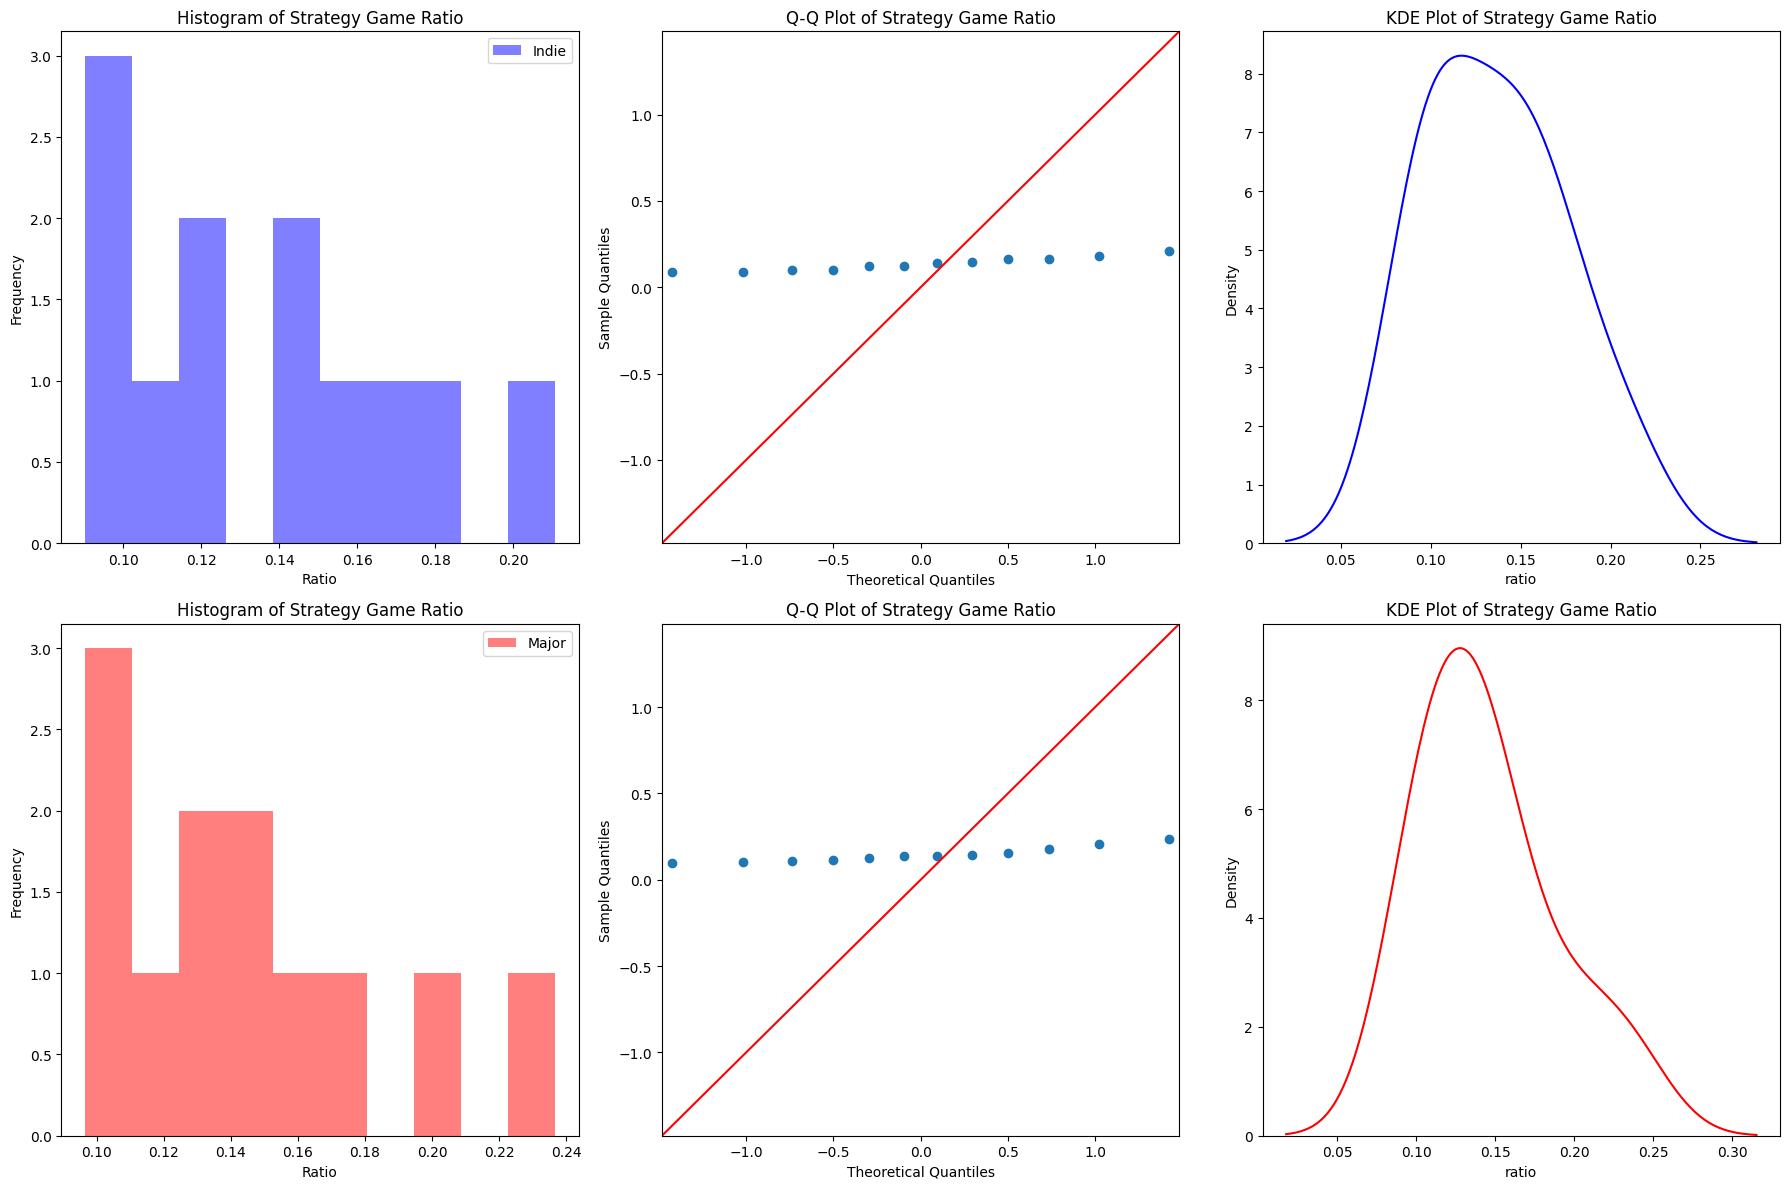

<< Simulation >>
[Indie] p-value: 0.7300916910171509 - 정규 분포를 따른다.
[Major] p-value: 0.6677854657173157 - 정규 분포를 따른다.



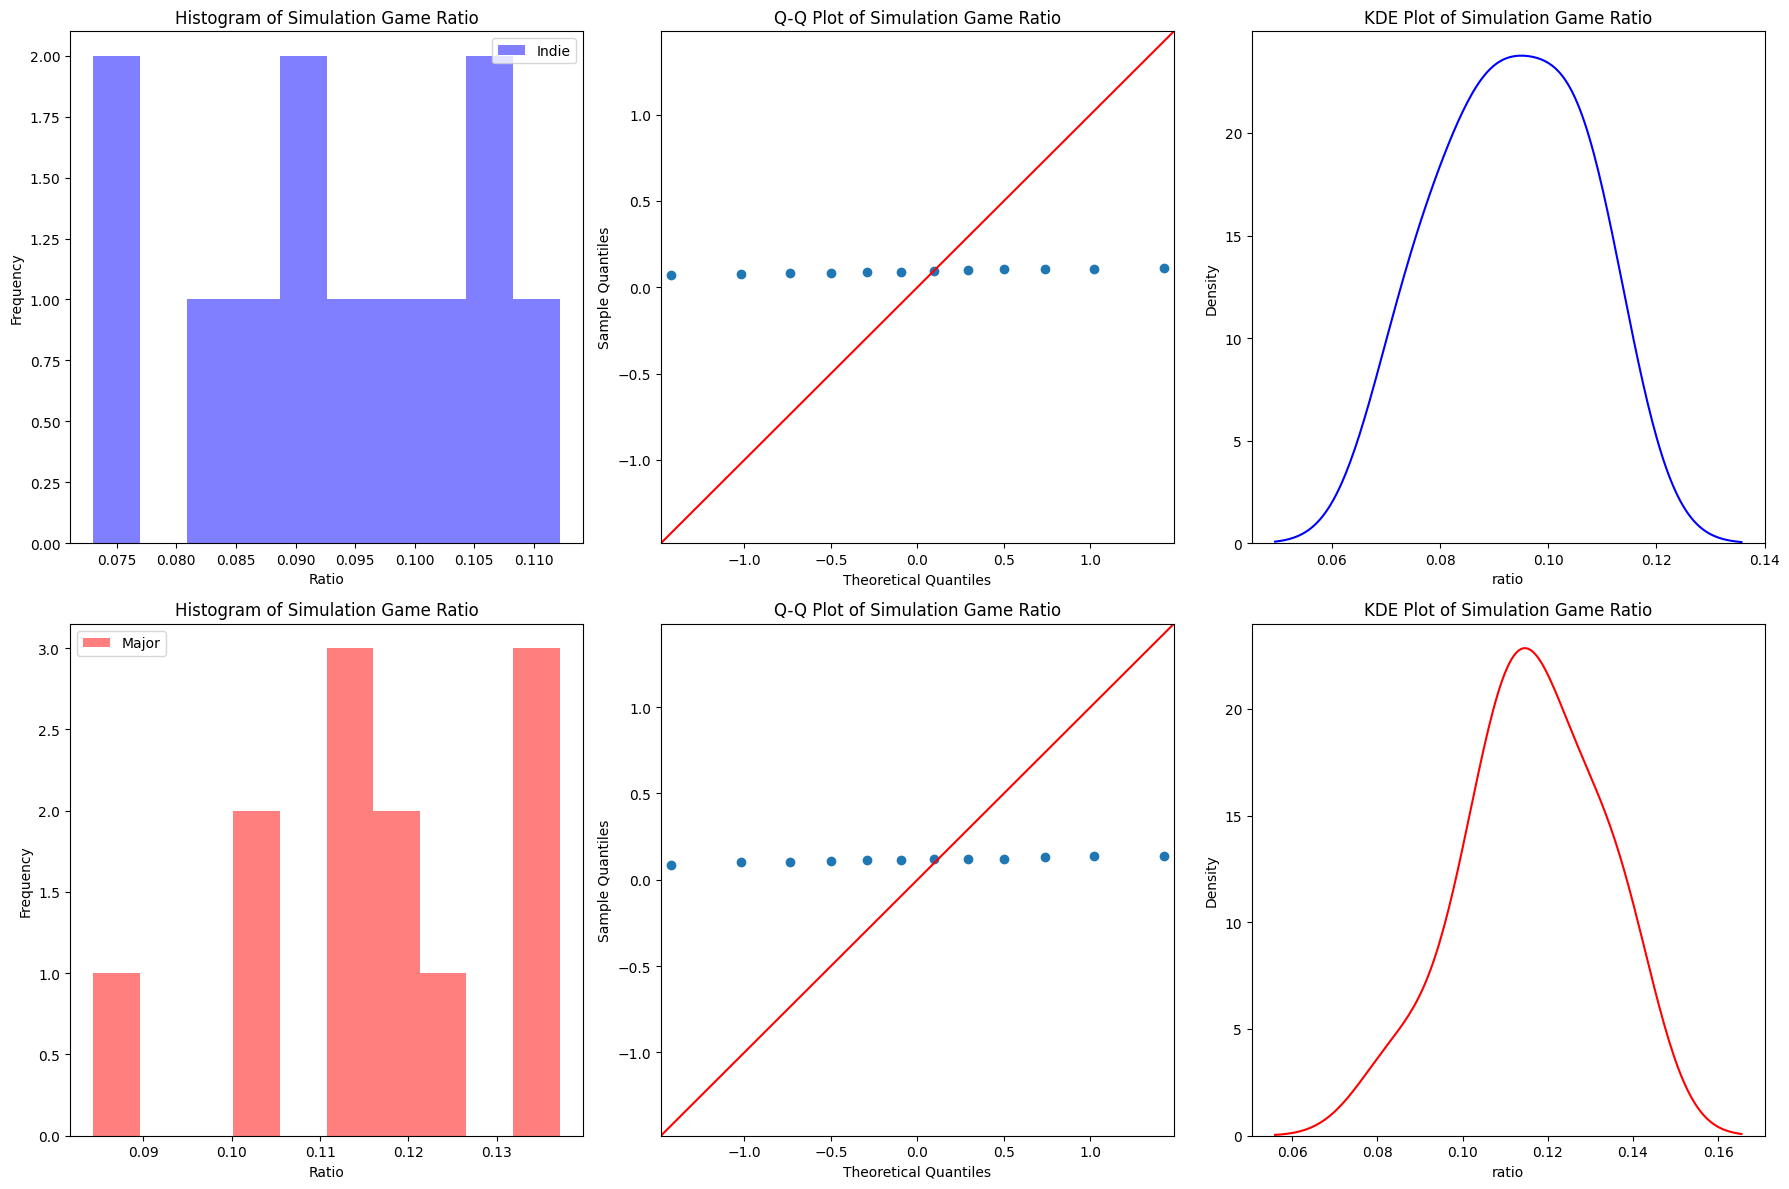

<< RPG >>
[Indie] p-value: 0.0962868183851242 - 정규 분포를 따른다.
[Major] p-value: 0.37179669737815857 - 정규 분포를 따른다.



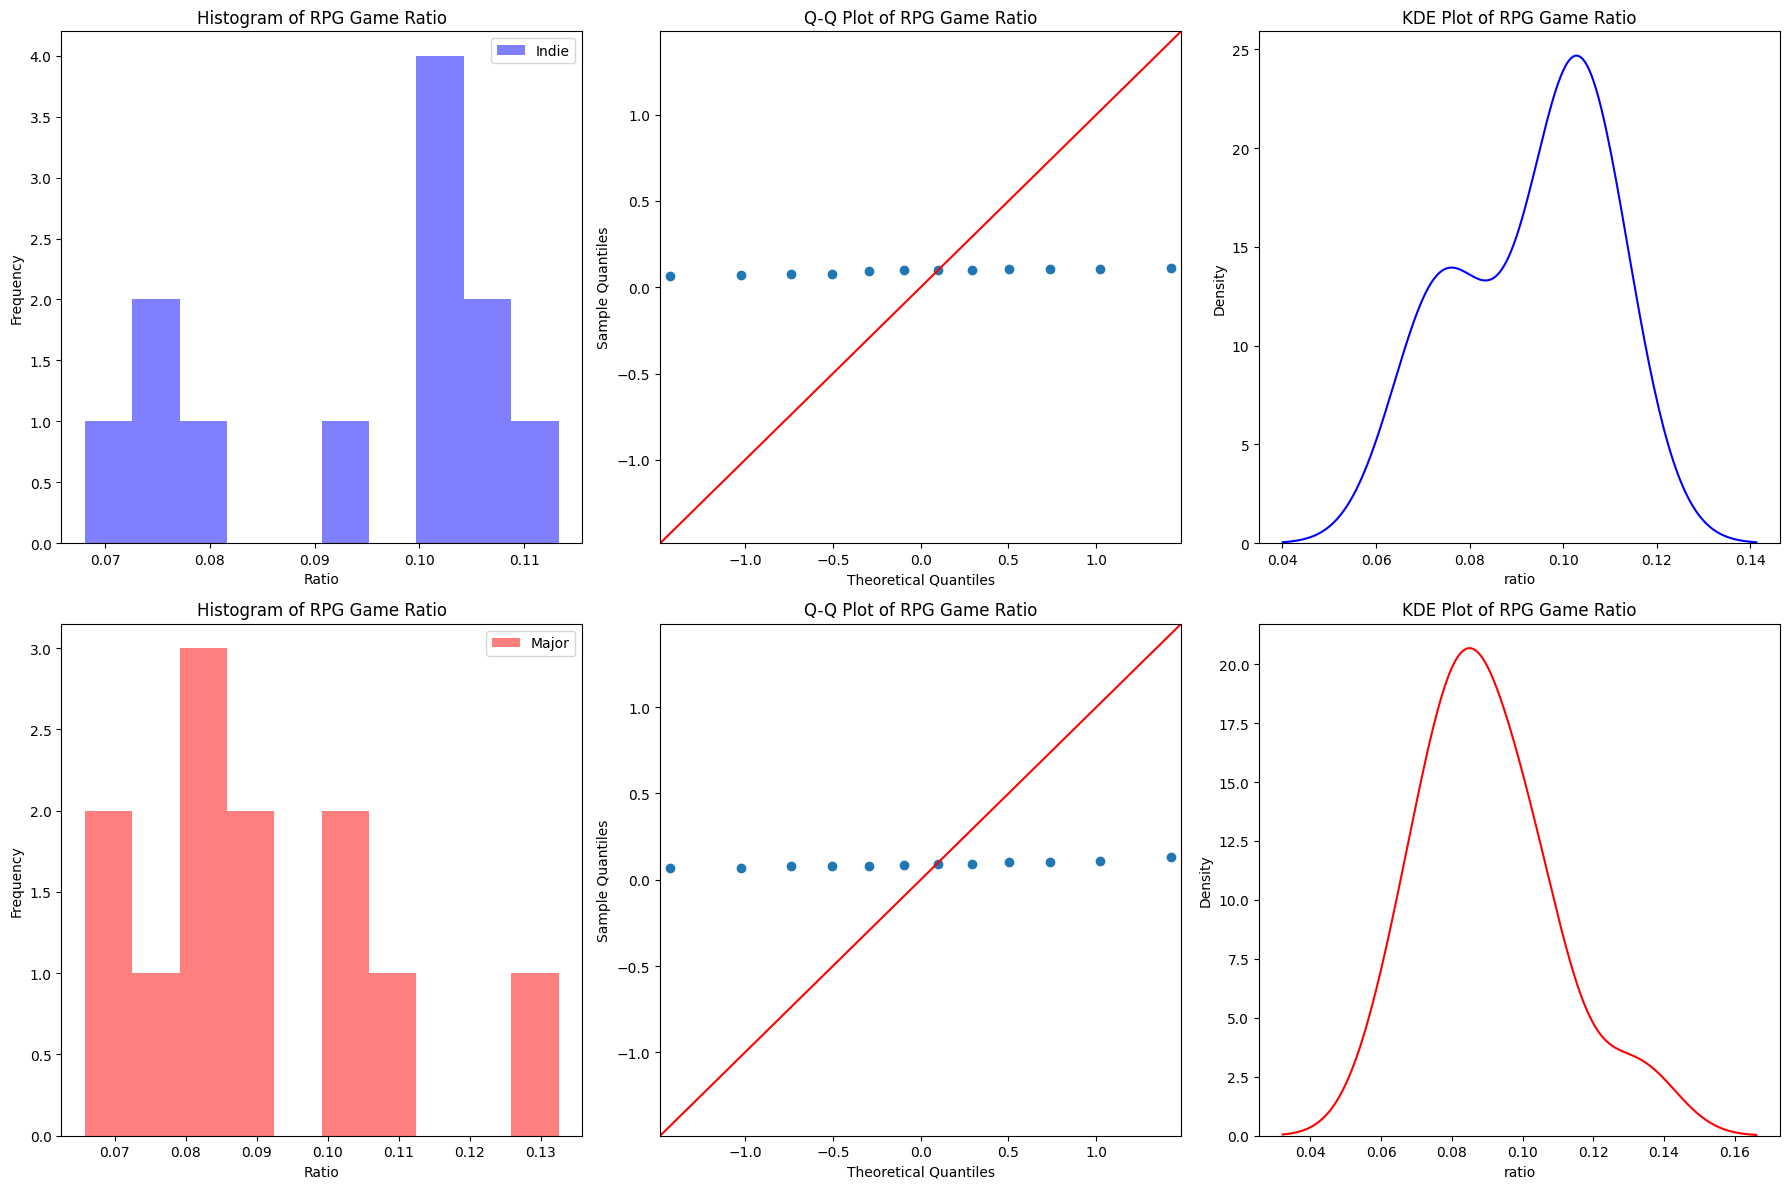

<< Racing >>
[Indie] p-value: 0.0003280669334344566 - 정규 분포를 따르지 않는다.
[Major] p-value: 0.14306578040122986 - 정규 분포를 따른다.



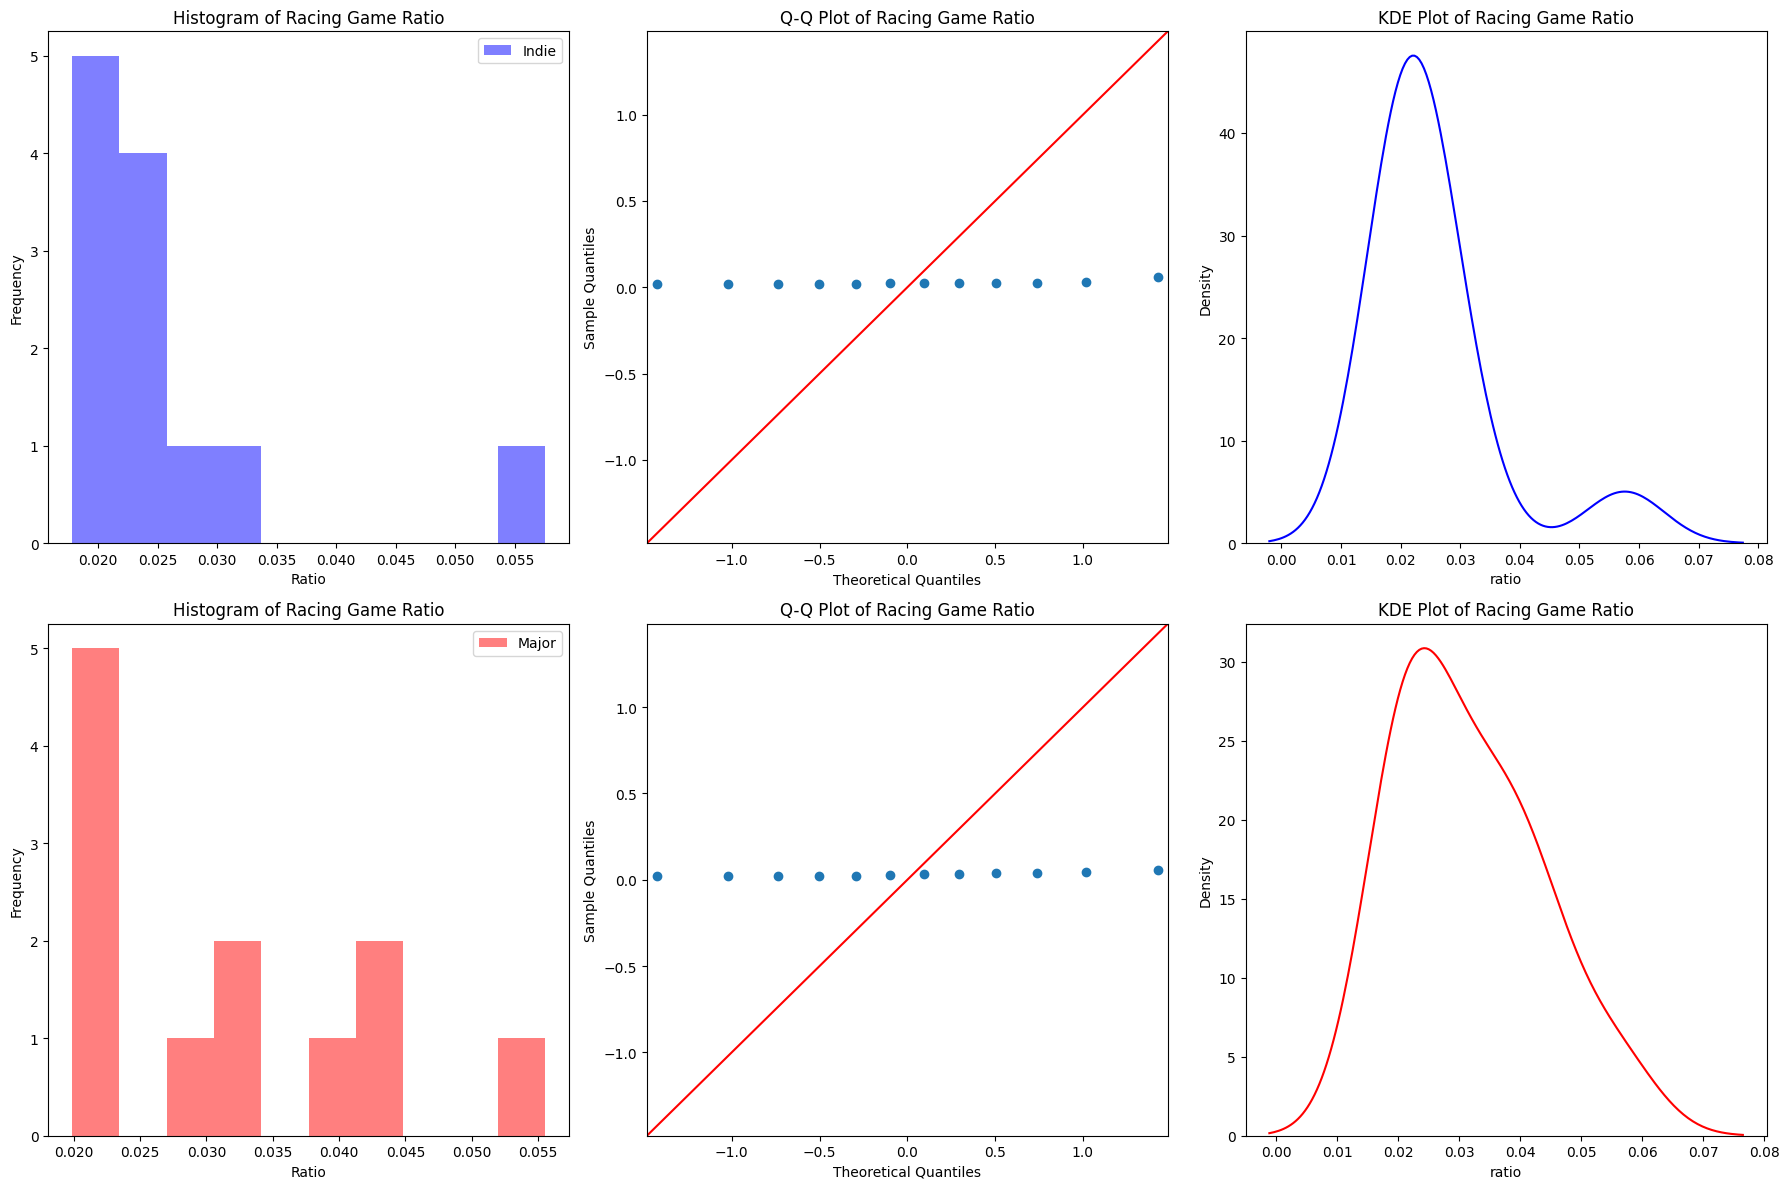

<< Sports >>
[Indie] p-value: 0.8129736185073853 - 정규 분포를 따른다.
[Major] p-value: 0.6381363272666931 - 정규 분포를 따른다.



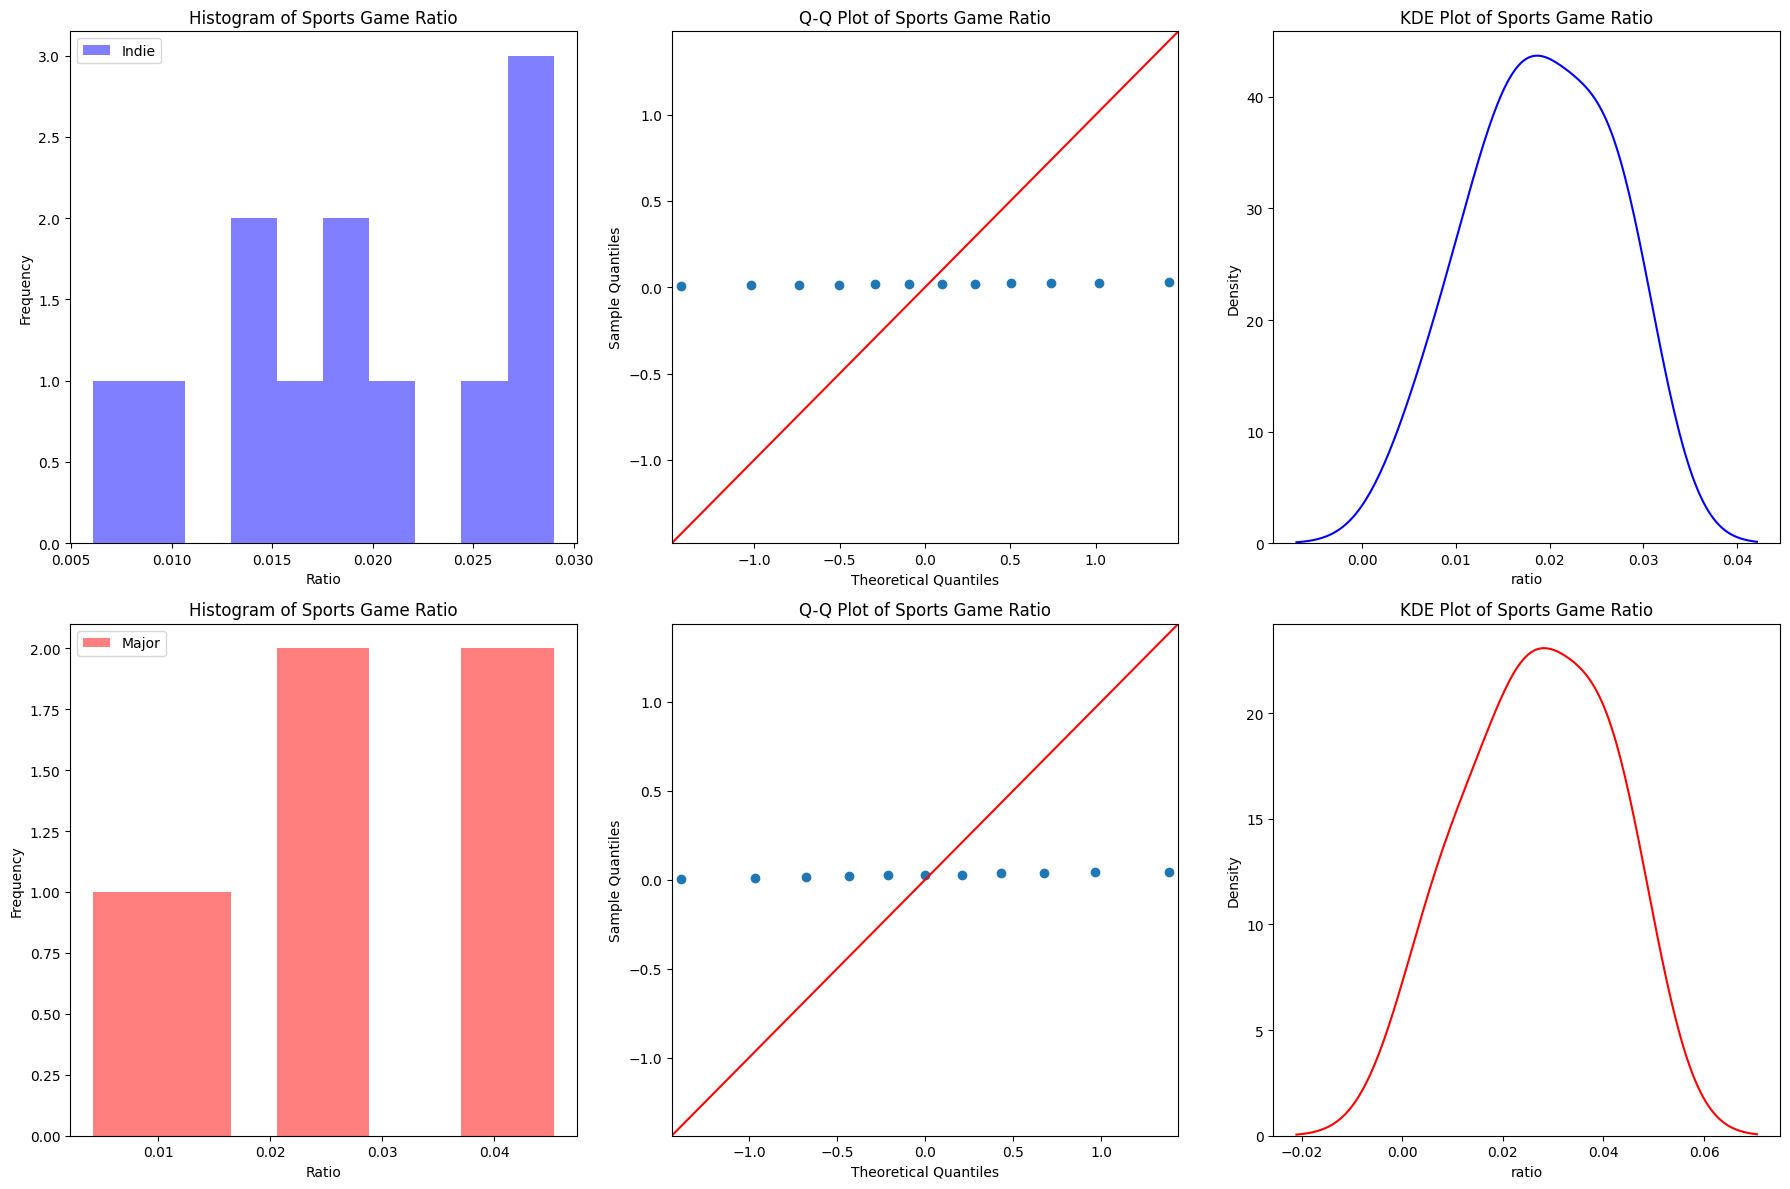

In [46]:
from scipy.stats import shapiro
import statsmodels.api as sm

# 정규성 검정 결과를 저장할 딕셔너리 생성
normality_test_results = {}

# 선택한 장르에 대해서만 데이터 필터링
indie_year_data_selected = indie_df[indie_df['genres'].isin(selected_genres)]
major_year_data_selected = major_df[major_df['genres'].isin(selected_genres)]

# Shapiro-Wilk 검정 실행 및 결과 저장
for genre in selected_genres:
    # 인디게임과 메이저 게임의 해당 장르 데이터 추출
    indie_genre_data = indie_year_data_selected[indie_year_data_selected['genres'] == genre]['ratio']
    major_genre_data = major_year_data_selected[major_year_data_selected['genres'] == genre]['ratio']

    # Shapiro-Wilk 검정 실행
    _, p_indie = shapiro(indie_genre_data)
    _, p_major = shapiro(major_genre_data)

    # 결과 저장
    normality_test_results[genre] = {'Indie': p_indie, 'Major': p_major}

    # 결과 출력
    print(f"<< {genre} >>")
    if normality_test_results[genre]['Indie'] > 0.05:
        print(f"[Indie] p-value: {normality_test_results[genre]['Indie']} - 정규 분포를 따른다.")
    else:
        print(f"[Indie] p-value: {normality_test_results[genre]['Indie']} - 정규 분포를 따르지 않는다.")
    if normality_test_results[genre]['Major'] > 0.05:
        print(f"[Major] p-value: {normality_test_results[genre]['Major']} - 정규 분포를 따른다.")
    else:
        print(f"[Major] p-value: {normality_test_results[genre]['Major']} - 정규 분포를 따르지 않는다.")
    print()

    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    # Indie 게임의 ratio 데이터로 히스토그램 생성
    axs[0, 0].hist(indie_genre_data, bins=10, color='blue', alpha=0.5, label='Indie')
    axs[0, 0].set_title(f'Histogram of {genre} Game Ratio')
    axs[0, 0].set_xlabel('Ratio')
    axs[0, 0].set_ylabel('Frequency')
    axs[0, 0].legend()

    # Major 게임의 ratio 데이터로 히스토그램 생성
    axs[1, 0].hist(major_genre_data, bins=10, color='red', alpha=0.5, label='Major')
    axs[1, 0].set_title(f'Histogram of {genre} Game Ratio')
    axs[1, 0].set_xlabel('Ratio')
    axs[1, 0].set_ylabel('Frequency')
    axs[1, 0].legend()

    # Indie 게임의 ratio 데이터로 Q-Q 플롯 생성
    sm.qqplot(np.array(indie_genre_data), line ='45', ax=axs[0, 1])
    axs[0, 1].set_title(f'Q-Q Plot of {genre} Game Ratio')

    # Major 게임의 ratio 데이터로 Q-Q 플롯 생성
    sm.qqplot(np.array(major_genre_data), line ='45', ax=axs[1, 1])
    axs[1, 1].set_title(f'Q-Q Plot of {genre} Game Ratio')

    # Indie 게임의 ratio 데이터로 KDE 플롯 생성
    sns.kdeplot(data=indie_genre_data, ax=axs[0, 2], color='blue')
    axs[0, 2].set_title(f'KDE Plot of {genre} Game Ratio')

    # Major 게임의 ratio 데이터로 KDE 플롯 생성
    sns.kdeplot(data=major_genre_data, ax=axs[1, 2], color='red')
    axs[1, 2].set_title(f'KDE Plot of {genre} Game Ratio')

    plt.tight_layout()
    plt.show()


- Indie의 'Racing' 장르 데이터는 정규 분포를 따르지 않는다.

### 2. Indie의 'Racing' 데이터 변환 (Box-Cox Transformation)

In [47]:
change_cols = ['Racing']

for genre in selected_genres:
    # 인디게임과 메이저 게임의 해당 장르 데이터 추출
    indie_genre_data = indie_year_data_selected[indie_year_data_selected['genres'] == genre]['ratio']

<< Racing >>


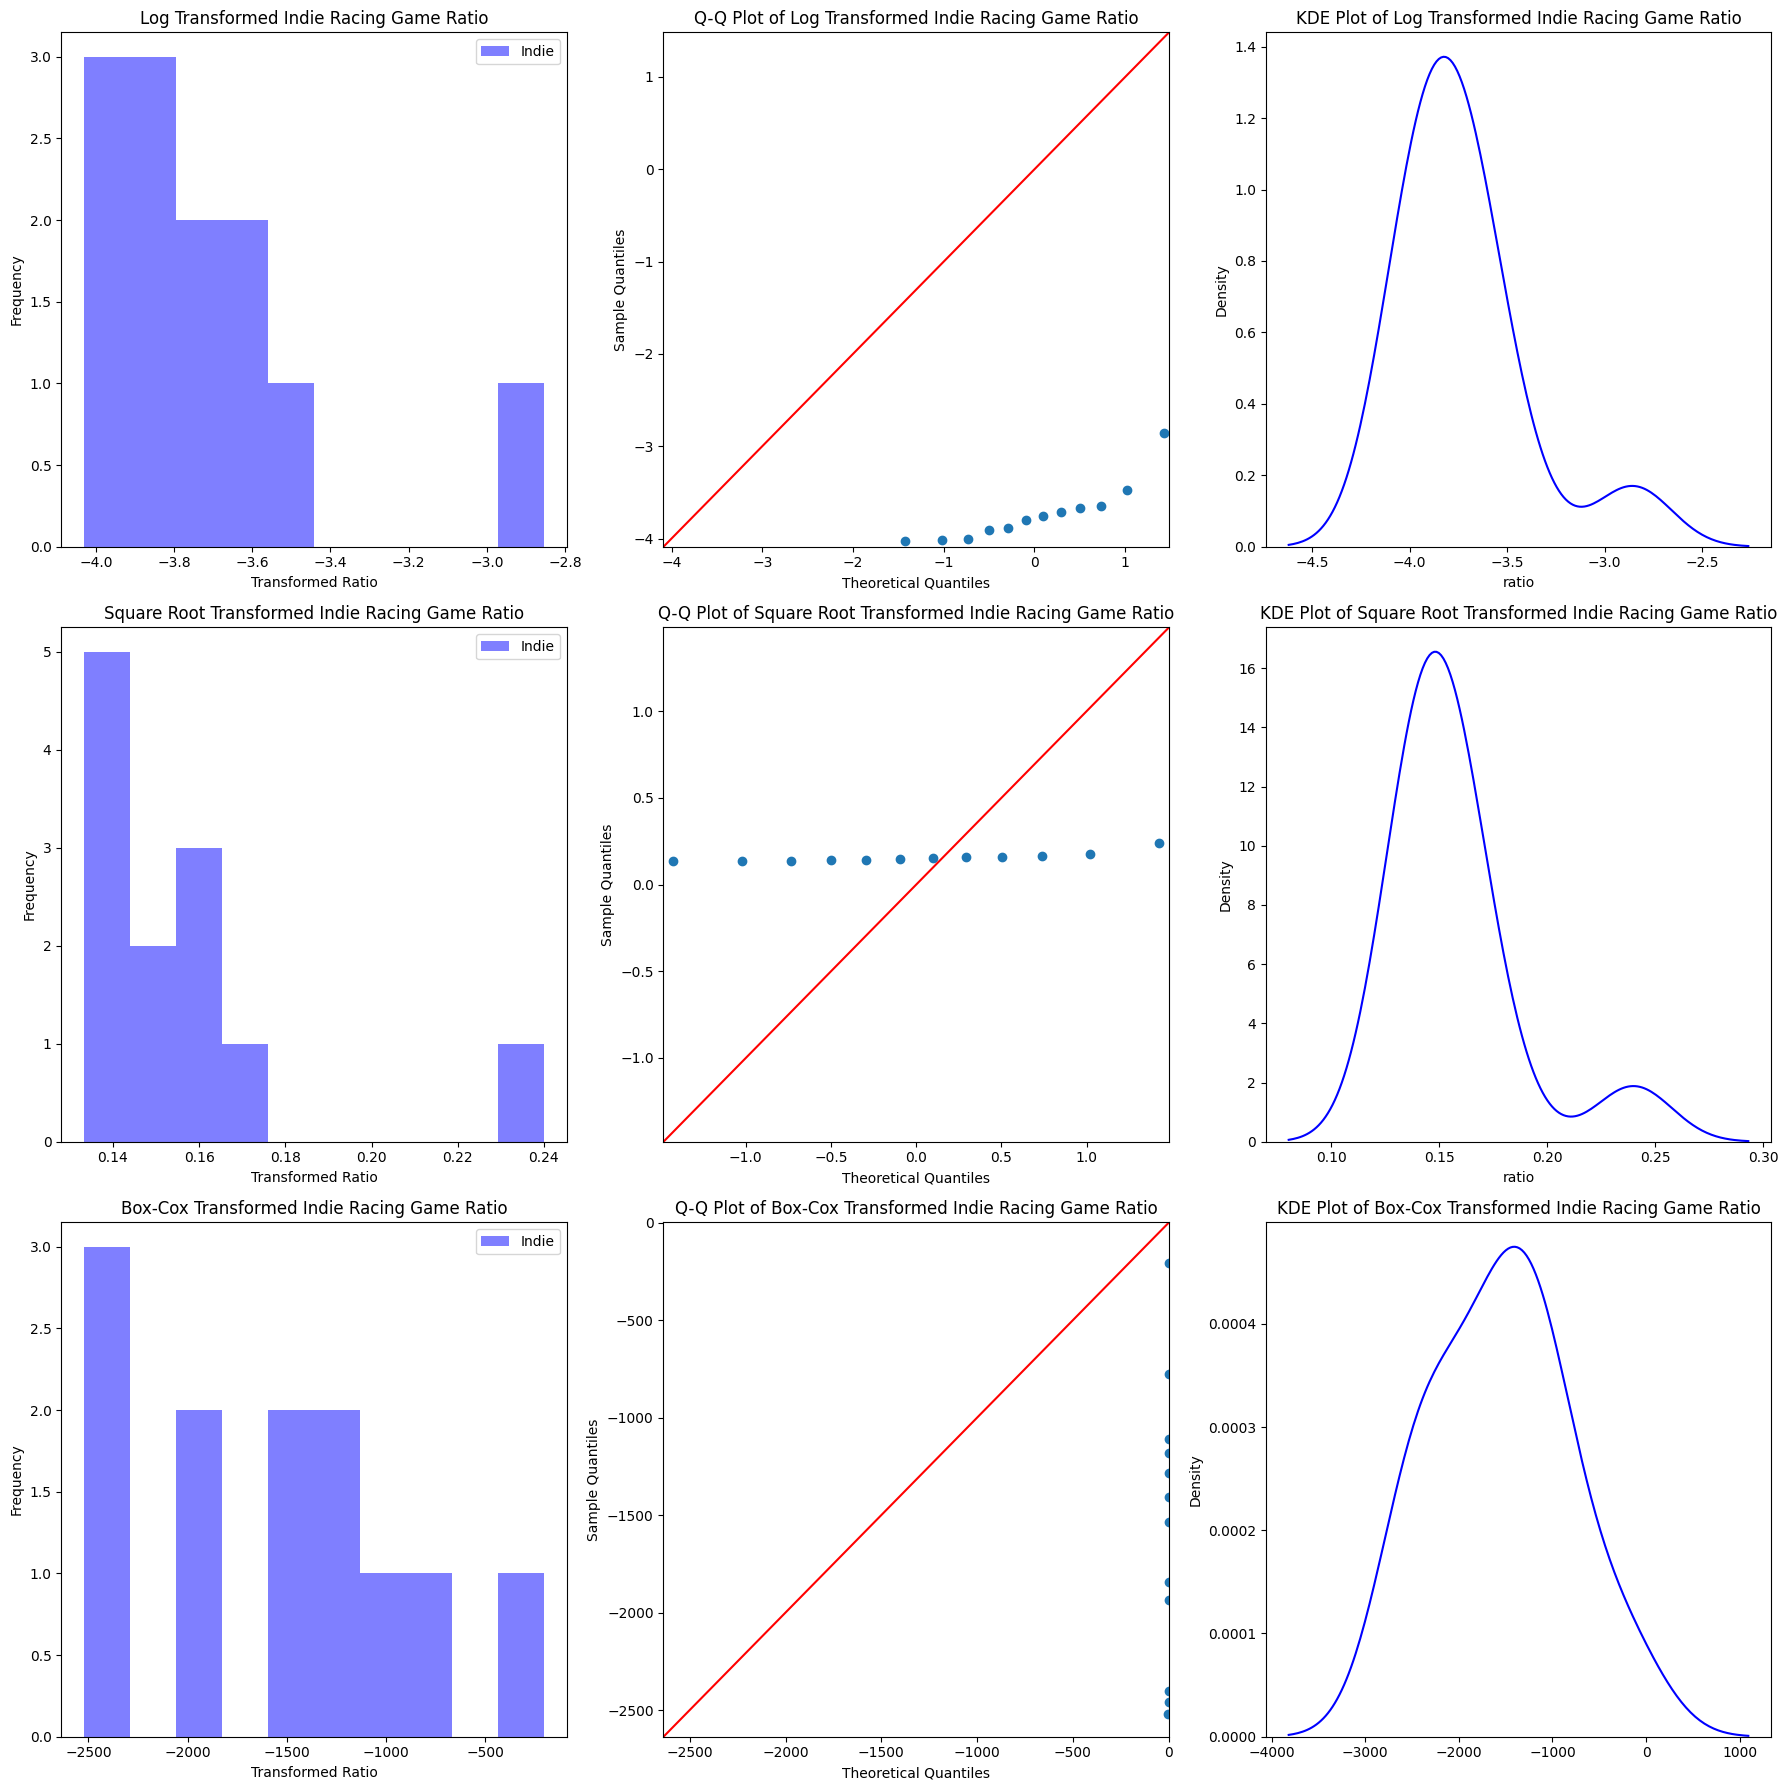

In [48]:
from scipy.stats import shapiro
import statsmodels.api as sm
from scipy.stats import boxcox

def transform_and_visualize(data, title):
    # 데이터 변환 1) 로그 변환
    data_log = np.log(data)
    # 데이터 변환 2) 제곱근 변환
    data_sqrt = np.sqrt(data)
    # 데이터 변환 3) Box-Cox 변환
    data_boxcox, _ = boxcox(data)

    fig, axs = plt.subplots(3, 3, figsize=(18, 18))

    # 히스토그램
    axs[0, 0].hist(data_log, bins=10, color='blue', alpha=0.5, label='Indie')
    axs[0, 0].set_title(f'Log Transformed {title}')
    axs[0, 0].set_xlabel('Transformed Ratio')
    axs[0, 0].set_ylabel('Frequency')
    axs[0, 0].legend()

    axs[1, 0].hist(data_sqrt, bins=10, color='blue', alpha=0.5, label='Indie')
    axs[1, 0].set_title(f'Square Root Transformed {title}')
    axs[1, 0].set_xlabel('Transformed Ratio')
    axs[1, 0].set_ylabel('Frequency')
    axs[1, 0].legend()

    axs[2, 0].hist(data_boxcox, bins=10, color='blue', alpha=0.5, label='Indie')
    axs[2, 0].set_title(f'Box-Cox Transformed {title}')
    axs[2, 0].set_xlabel('Transformed Ratio')
    axs[2, 0].set_ylabel('Frequency')
    axs[2, 0].legend()

    # Q-Q plot
    sm.qqplot(np.array(data_log), line='45', ax=axs[0, 1])
    axs[0, 1].set_title(f'Q-Q Plot of Log Transformed {title}')

    sm.qqplot(np.array(data_sqrt), line='45', ax=axs[1, 1])
    axs[1, 1].set_title(f'Q-Q Plot of Square Root Transformed {title}')

    sm.qqplot(np.array(data_boxcox), line='45', ax=axs[2, 1])
    axs[2, 1].set_title(f'Q-Q Plot of Box-Cox Transformed {title}')

    # KDE plot
    sns.kdeplot(data=data_log, ax=axs[0, 2], color='blue')
    axs[0, 2].set_title(f'KDE Plot of Log Transformed {title}')

    sns.kdeplot(data=data_sqrt, ax=axs[1, 2], color='blue')
    axs[1, 2].set_title(f'KDE Plot of Square Root Transformed {title}')

    sns.kdeplot(data=data_boxcox, ax=axs[2, 2], color='blue')
    axs[2, 2].set_title(f'KDE Plot of Box-Cox Transformed {title}')

    plt.tight_layout()
    plt.show()


# 인디 게임의 Racing 장르 데이터 추출
indie_racing_data = indie_year_data_selected[indie_year_data_selected['genres'] == 'Racing']['ratio']

# 로그 변환 및 시각화
print("<< Racing >>")
transform_and_visualize(indie_racing_data, 'Indie Racing Game Ratio')

- Indie의 ['Adventure', 'Racing', 'Sports'] 데이터 모두 정규 분포를 따르도록 변환된 방법 : Box-Cox 변환

### 3. 상관관계 확인 (Pearson correlation coefficient)

In [49]:
# Indie 게임과 Non-Indie 게임 데이터 프레임 생성
indie_df = pd.DataFrame(genre_counts_by_year_indie)
major_df = pd.DataFrame(genre_counts_by_year_not_indie)

# 메이저 게임 데이터에 2008년 Sports 데이터가 없음으로 추가
new_row = pd.DataFrame({'release_year': [2008], 'genres': ['Sports'], 'counts': [0], 'ratio': [0]})
major_df = pd.concat([major_df, new_row], ignore_index=True)

# 분석에 사용할 모든 장르 리스트
selected_genres = ['Action', 'Adventure', 'Casual', 'Strategy', 'Simulation', 'RPG', 'Racing', 'Sports']

# 선택한 장르에 대해서만 데이터 필터링
indie_year_data_selected = indie_df[indie_df['genres'].isin(selected_genres)]
major_year_data_selected = major_df[major_df['genres'].isin(selected_genres)]

In [50]:
indie_year_data_selected['type'] = 'indie'
major_year_data_selected['type'] = 'major'
merged_df = result = pd.concat([indie_year_data_selected, major_year_data_selected], axis=0)
merged_df

,release_year,genres,counts,ratio,type
0,2008,Action,61,0.319372,indie
1,2008,Adventure,23,0.120419,indie
2,2008,Casual,33,0.172775,indie
3,2008,RPG,13,0.068063,indie
4,2008,Racing,11,0.057592,indie
...,...,...,...,...,...
170,2019,Racing,17,0.019860,major
171,2019,Simulation,105,0.122664,major
172,2019,Sports,20,0.023364,major
173,2019,Strategy,96,0.112150,major


In [51]:
from scipy.stats import pearsonr

# 인디 게임과 메이저 게임 간의 출시 비율 데이터 추출
indie_ratio = merged_df[merged_df['type'] == 'indie']['ratio']
major_ratio = merged_df[merged_df['type'] == 'major']['ratio']

# 피어슨 상관계수 계산
correlation, p_value = pearsonr(indie_ratio, major_ratio)

# 결과 출력
print(f'Pearson correlation coefficient: {correlation}')
print(f'p-value: {p_value}')

Pearson correlation coefficient: 0.3506962594899621
p-value: 0.0004599742691984376


In [52]:
from scipy.stats import pearsonr

# 결과를 저장할 데이터프레임 생성
results = pd.DataFrame(columns=['Genre', 'Pearson Correlation', 'p-value'])

# 'genres' 열을 기준으로 데이터프레임을 그룹화하고 각 그룹에 대해 피어슨 상관분석 수행
for genre, group in merged_df.groupby('genres'):
    indie_ratio = group[group['type'] == 'indie']['ratio']
    major_ratio = group[group['type'] == 'major']['ratio']

    # 인디 게임과 메이저 게임 간의 출시 비율 데이터 추출
    if len(indie_ratio) > 1 and len(major_ratio) > 1:  # 적어도 두 개의 샘플이 필요
        # 피어슨 상관계수 계산
        correlation, p_value = pearsonr(indie_ratio, major_ratio)

        # 결과를 데이터프레임에 추가
        results = results.append({'Genre': genre, 'Pearson Correlation': correlation, 'p-value': p_value}, ignore_index=True)

# 결과 출력
print(results)

        Genre  Pearson Correlation       p-value
0      Action             0.882661  1.434112e-04
1   Adventure             0.869757  2.362364e-04
2      Casual             0.953692  1.551356e-06
3         RPG             0.754372  4.582035e-03
4      Racing             0.805103  1.580267e-03
5  Simulation             0.756699  4.387769e-03
6      Sports             0.371912  2.338776e-01
7    Strategy             0.966262  3.252702e-07


<ipython-input-52-f5873850e854>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Genre': genre, 'Pearson Correlation': correlation, 'p-value': p_value}, ignore_index=True)
<ipython-input-52-f5873850e854>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Genre': genre, 'Pearson Correlation': correlation, 'p-value': p_value}, ignore_index=True)
<ipython-input-52-f5873850e854>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Genre': genre, 'Pearson Correlation': correlation, 'p-value': p_value}, ignore_index=True)
<ipython-input-52-f5873850e854>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

- 확인한 장르 모두 양의 상관관계를 가지고 있는 것을 확인할 수 있다.
- 장르에 따라 상관관계의 정도는 다르게 나타난다.
  - 대부분의 장르에서 강한 양의 상관관계를 나타낸다.
  - 하지만 Racing의 경우, 다른 장르들에 비해 약한 상관관계를 보인다.


### 카이제곱 검정 (Chi-square Test)

- 장르별로 인디 게임의 출시 게임 수의 분포와 메이저 게임의 출시 게임 수의 분포에 대하여 검증 진행

  - 귀무 가설: 인디 게임과 메이저 게임의 장르별 출시된 게임 수의 분포가 동일하다.
  - 대립 가설: 인디 게임과 메이저 게임의 장르별 출시된 게임 수의 분포가 동일하지 않다.

In [53]:
from scipy.stats import chi2_contingency

cross_tab = pd.crosstab(index=merged_df['type'], columns=merged_df['genres'], values=merged_df['counts'], aggfunc='sum')

chi2, p, dof, expected = chi2_contingency(cross_tab)

print(f'Chi-squared: {chi2}, p-value: {p}')

Chi-squared: 241.34985226066715, p-value: 1.9187886742201395e-48


- p-value 값이 유의 수준(0.05)보다 작으므로 귀무 가설을 기각하고 대립가설을 채택한다.
- 인디 게임과 메이저 게임은 장르별 출시된 게임 수의 분포가 다르다.
